In [1]:
import params, os, funcs
from jaratoolbox import celldatabase, settings
import numpy as np

# Load dataframe
databaseDir = os.path.join(settings.DATABASE_PATH, '2024popanalysis')
fullDbPath = 'celldb_2024popanalysis.h5'
fullPath = os.path.join(databaseDir, fullDbPath)
fullDb = celldatabase.load_hdf(fullPath)
simpleSiteNames = fullDb["recordingSiteName"].str.split(',').apply(lambda x: x[0])
simpleSiteNames = simpleSiteNames.replace("Posterior auditory area", "Dorsal auditory area")
fullDb["recordingSiteName"] = simpleSiteNames
fullDb.head()

/Volumes/NardociData/jarahubdata/figuresdata/2024popanalysis/celldb_2024popanalysis.h5 does not exist or cannot be opened.


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Volumes/NardociData/jarahubdata/figuresdata/2024popanalysis/celldb_2024popanalysis.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [2]:
X_speech_all, Y_brain_area_speech_all, X_AM_all = {}, {}, {}
Y_brain_area_AM_all, X_pureTones_all, Y_brain_area_PT_all = {}, {}, {}
previous_frequency_speech, previous_frequency_AM, previous_frequency_PT = None, None, None
indices_AM, indices_PT, indices_speech = None, None, None

# Initialize dictionaries for each spike window
for window_name in params.spike_windows:
    if "speech" in window_name:
        X_speech_all[window_name] = []
        Y_brain_area_speech_all[window_name] = []
    if "am" in window_name:
        X_AM_all[window_name] = []
        Y_brain_area_AM_all[window_name] = []
    if "pt" in window_name:
        X_pureTones_all[window_name] = []
        Y_brain_area_PT_all[window_name] = []

In [3]:
# Add data to the dictionary for each brain area and sound type
for subject in params.subject_list:
    for date in params.recordingDate_list[subject]:
        for brain_area in params.targetSiteNames:
            speechEnsemble, speechEphys, speechBdata = funcs.load_data(subject, date, brain_area, "FTVOTBorders")

            if speechEnsemble:
                X_speech_dict, Y_brain_area_speech, Y_frequency_speech = funcs.spike_rate("speech", speechEnsemble, speechEphys, speechBdata, brain_area)
                for window_name, X_speech in X_speech_dict.items():
                    X_speech_array, Y_frequency_speech_sorted, previous_frequency_speech, indices_speech = (
                        funcs.adjust_speech_length(subject, date, brain_area, X_speech, Y_frequency_speech,
                                                   Y_brain_area_speech, previous_frequency_speech))
                    
                    if X_speech_array is not None:
                        Y_frequency_FT = Y_frequency_speech_sorted[:, 0]
                        Y_frequency_VOT = Y_frequency_speech_sorted[:, 1]
                
                        X_speech_all[window_name].extend(X_speech_array)
                        Y_brain_area_speech_all[window_name].extend(Y_brain_area_speech)

            # Load and process data for AM
            amEnsemble, amEphys, amBdata = funcs.load_data(subject, date, brain_area, "AM")
            if amEnsemble:
                X_AM_dict, Y_brain_area_AM, Y_frequency_AM = funcs.spike_rate("am", amEnsemble, amEphys, amBdata, 
                                                                        brain_area)
                
                for window_name, X_AM in X_AM_dict.items():
                    # Apply adjustments
                    X_AM_adjusted, Y_frequency_AM_adjusted, Yba_AM_adj = (
                        funcs.adjust_array_and_labels(X_AM, Y_frequency_AM, Y_brain_area_AM, 
                                                      params.max_trials['AM'], subject, date, brain_area))
                
                    # Sort arrays
                    X_AM_array, Y_frequency_AM_sorted, Y_brain_area_AM_sorted, previous_frequency_AM, indices_AM = (
                        funcs.sort_sound_array(subject, date, brain_area, X_AM_adjusted, Yba_AM_adj, Y_frequency_AM_adjusted, previous_frequency_AM))
                
                    X_AM_all[window_name].extend(X_AM_array)
                    Y_brain_area_AM_all[window_name].extend(Y_brain_area_AM_sorted)
                        
            # Load and process data for PT
            ptEnsemble, ptEphys, ptBdata = funcs.load_data(subject, date, brain_area, "pureTones")
            if ptEnsemble:
                X_PT_dict, Y_brain_area_PT, Y_frequency_pureTones = funcs.spike_rate("pt", ptEnsemble, ptEphys, ptBdata, 
                                                                        brain_area)
                for window_name, X_PT in X_PT_dict.items():
                    # Apply adjustments
                    X_PT_adjusted, Y_frequency_PT_adjusted, Yba_PT_adj = (
                        funcs.adjust_array_and_labels(X_PT, Y_frequency_pureTones, Y_brain_area_PT, 
                                                      params.max_trials['PT'], subject, date, brain_area))
                
                    # Sort arrays
                    X_PT_array, Y_frequency_PT_sorted, Y_brain_area_PT_sorted, previous_frequency_PT, indices_PT = (
                        funcs.sort_sound_array(subject, date, brain_area, X_PT_adjusted, Yba_PT_adj, 
                                               Y_frequency_PT_adjusted, previous_frequency_PT))
                
                    if X_PT_array is not None:
                        X_pureTones_all[window_name].extend(X_PT_array)
                        Y_brain_area_PT_all[window_name].extend(Y_brain_area_PT_sorted)

No FTVOTBorder data for Primary auditory area on 2022-01-11 for feat004
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Primary auditory area.
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Primary auditory area.
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Primary auditory area.
No FTVOTBorder data for Dorsal auditory area on 2022-01-11 for feat004
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Dorsal auditory area.
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Dorsal auditory area.
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Dorsal auditory area.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No FTVOTBorder data for Primary aud

KeyboardInterrupt: 

In [22]:
# AM
X_AM_dict = {}
Y_brain_area_AM_all_renamed = {}

for window_name, X_AM_list in X_AM_all.items():
    simple_name = params.window_name_mapping.get(window_name, window_name)
    X_AM_sorted = funcs.sort_x_arrays(X_AM_list, indices_AM, "am")
    X_AM_array = np.stack(X_AM_sorted, axis=0)
    X_AM_dict[simple_name] = X_AM_array

    if window_name in Y_brain_area_AM_all:
        Y_brain_area_AM_all_renamed[simple_name] = Y_brain_area_AM_all[window_name]

# PT
X_PT_dict = {}
Y_brain_area_PT_all_renamed = {}

for window_name, X_PT_list in X_pureTones_all.items():
    simple_name = params.window_name_mapping.get(window_name, window_name)
    X_PT_sorted = funcs.sort_x_arrays(X_PT_list, indices_PT, "pt")
    X_PT_array = np.stack(X_PT_sorted, axis=0)
    X_PT_dict[simple_name] = X_PT_array

    if window_name in Y_brain_area_PT_all:
        Y_brain_area_PT_all_renamed[simple_name] = Y_brain_area_PT_all[window_name]

# Speech
X_speech_dict = {}
Y_brain_area_speech_all_renamed = {}

for window_name, X_speech_list in X_speech_all.items():
    simple_name = params.window_name_mapping.get(window_name, window_name)
    X_speech_sorted = funcs.sort_x_arrays(X_speech_list, indices_speech, "speech")
    X_speech_array = np.stack(X_speech_sorted, axis=0)
    X_speech_dict[simple_name] = X_speech_array

    if window_name in Y_brain_area_speech_all:
        Y_brain_area_speech_all_renamed[simple_name] = Y_brain_area_speech_all[window_name]

In [23]:
print(f"AM Onset Shape: {X_AM_dict['onset'].shape}")
print(f"AM Sustained Shape: {X_AM_dict['sustained'].shape}")
print(f"AM Offset Shape: {X_AM_dict['offset'].shape}")

print(f"PT Onset Shape: {X_PT_dict['onset'].shape}")
print(f"PT Sustained Shape: {X_PT_dict['sustained'].shape}")
print(f"PT Offset Shape: {X_PT_dict['offset'].shape}")

print(f"Speech Onset Shape: {X_speech_dict['onset'].shape}")
print(f"Speech Sustained Shape: {X_speech_dict['sustained'].shape}")
print(f"Speech Offset Shape: {X_speech_dict['offset'].shape}")

AM Onset Shape: (557, 220)
AM Sustained Shape: (557, 220)
AM Offset Shape: (557, 220)
PT Onset Shape: (431, 640)
PT Sustained Shape: (431, 640)
PT Offset Shape: (431, 640)
Speech Onset Shape: (400, 381)
Speech Sustained Shape: (400, 381)
Speech Offset Shape: (400, 381)


In [24]:
data_dict = {}

for brain_area in params.targetSiteNames:
    for window_name in X_speech_dict:
        brain_area_mask = np.array(Y_brain_area_speech_all_renamed[window_name]) == brain_area
        X_array = X_speech_dict[window_name][brain_area_mask].T
        data_dict[(brain_area, 'speech', window_name)] = {'X': X_array, 'Y': Y_frequency_speech_sorted}

    for window_name in X_AM_dict:
        brain_area_mask = np.array(Y_brain_area_AM_all_renamed[window_name]) == brain_area
        X_array = X_AM_dict[window_name][brain_area_mask].T
        data_dict[(brain_area, 'AM', window_name)] = {'X': X_array, 'Y': Y_frequency_AM_sorted}

    for window_name in X_PT_dict:
        brain_area_mask = np.array(Y_brain_area_PT_all_renamed[window_name]) == brain_area
        X_array = X_PT_dict[window_name][brain_area_mask].T
        data_dict[(brain_area, 'PT', window_name)] = {'X': X_array, 'Y': Y_frequency_PT_sorted}
        
data_dict[('Ventral auditory area', 'AM', 'onset')]['X'].shape

(220, 119)

## D-prime discriminability

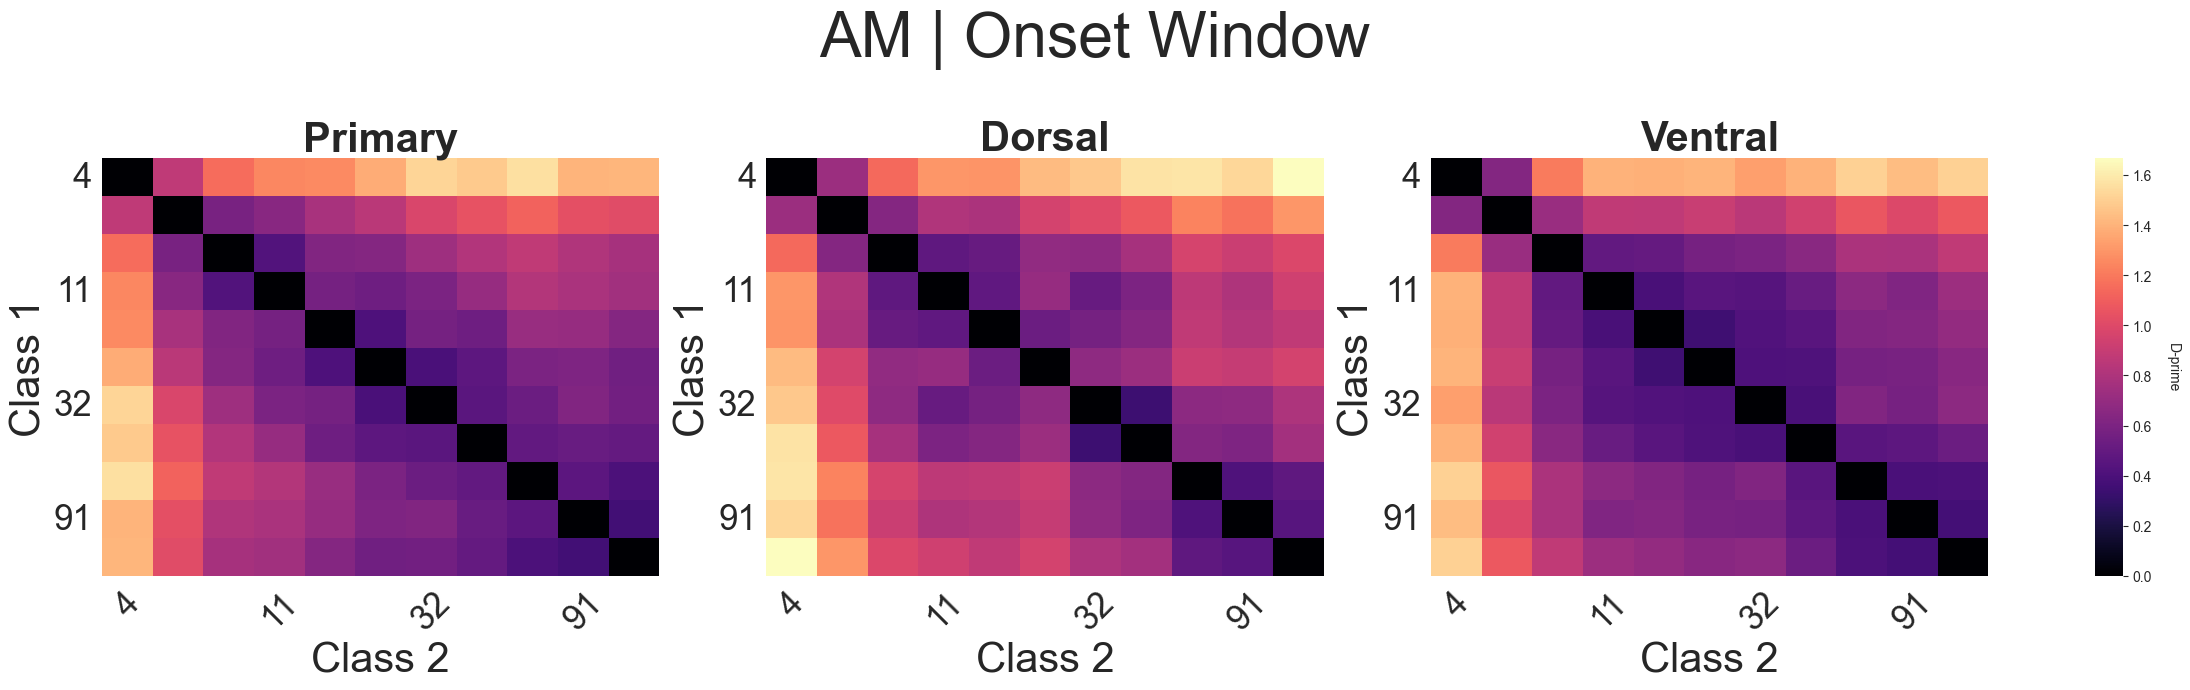

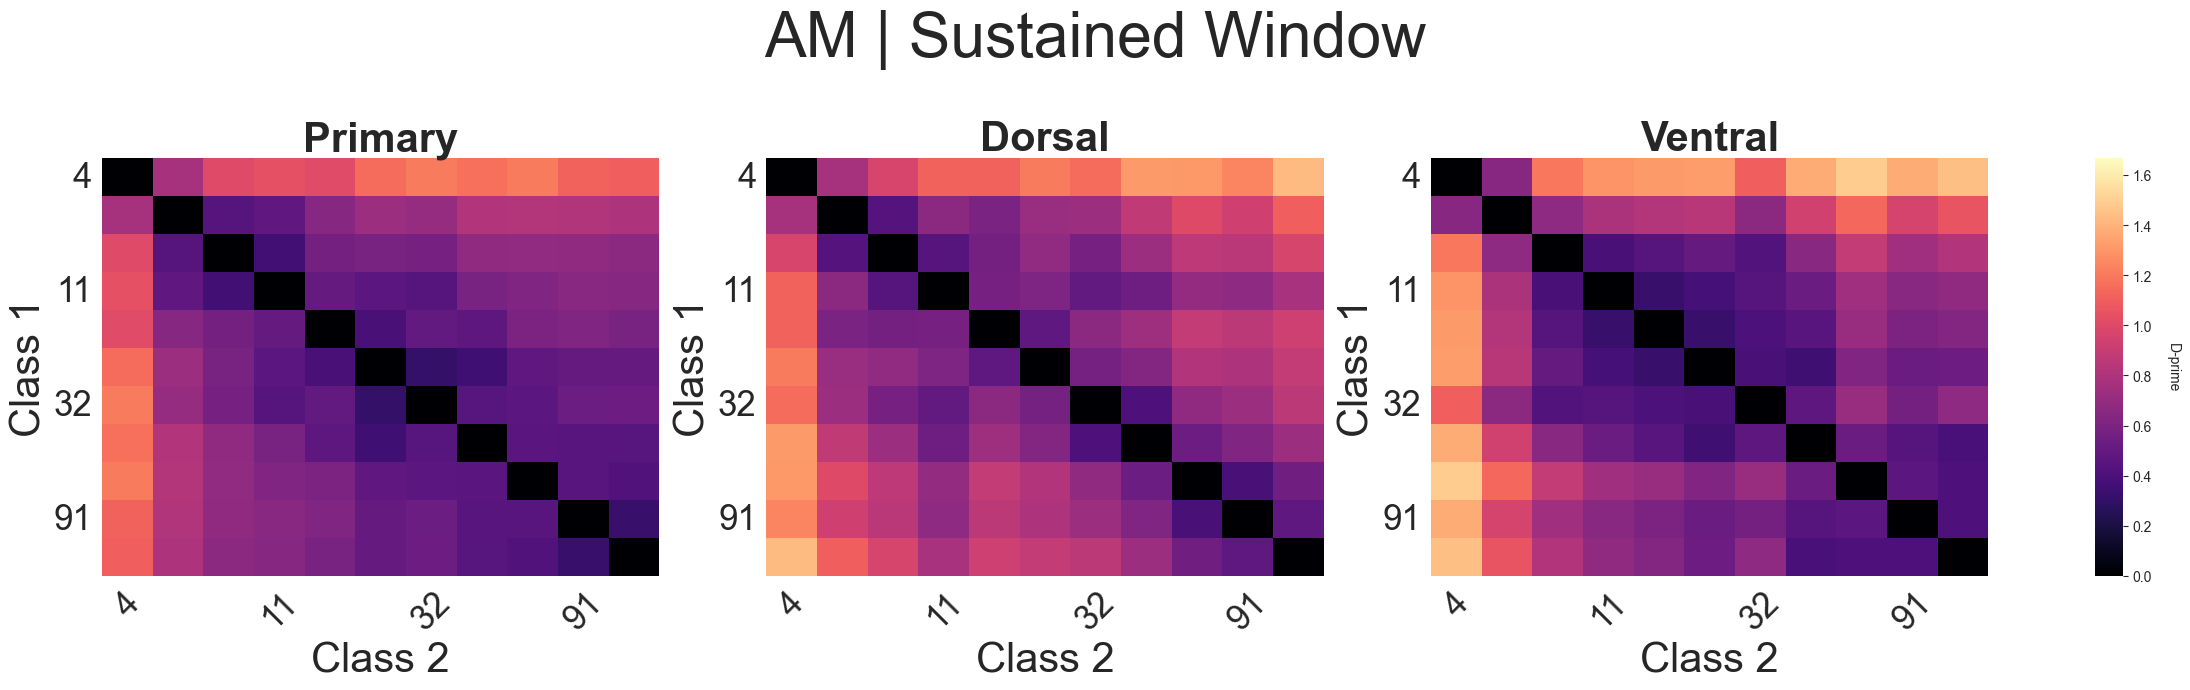

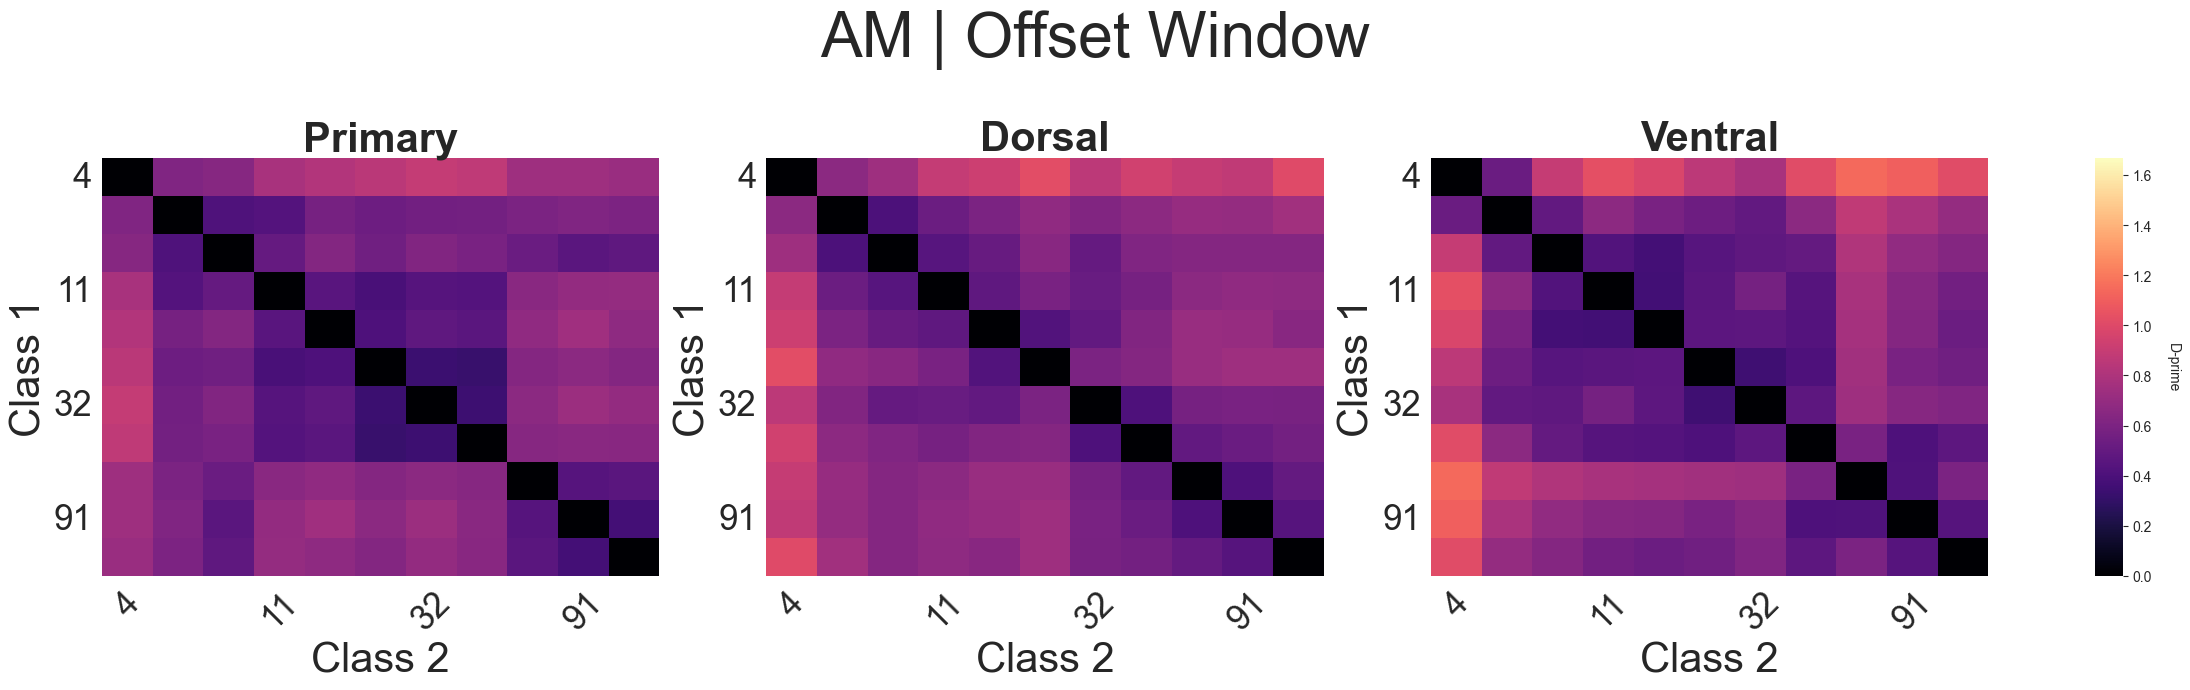

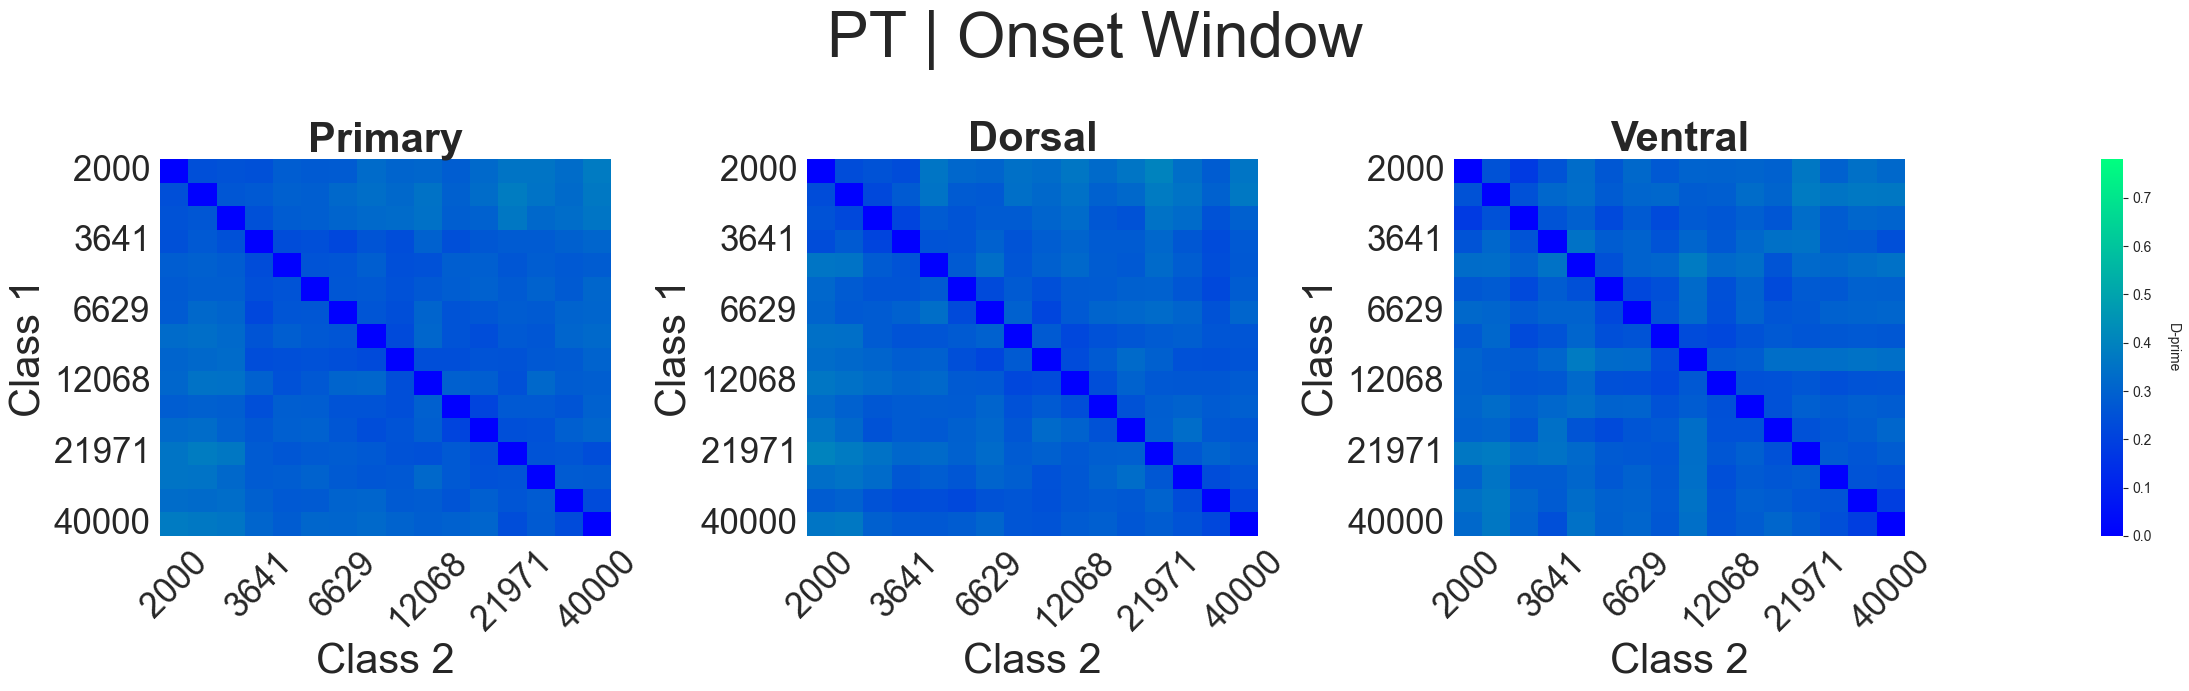

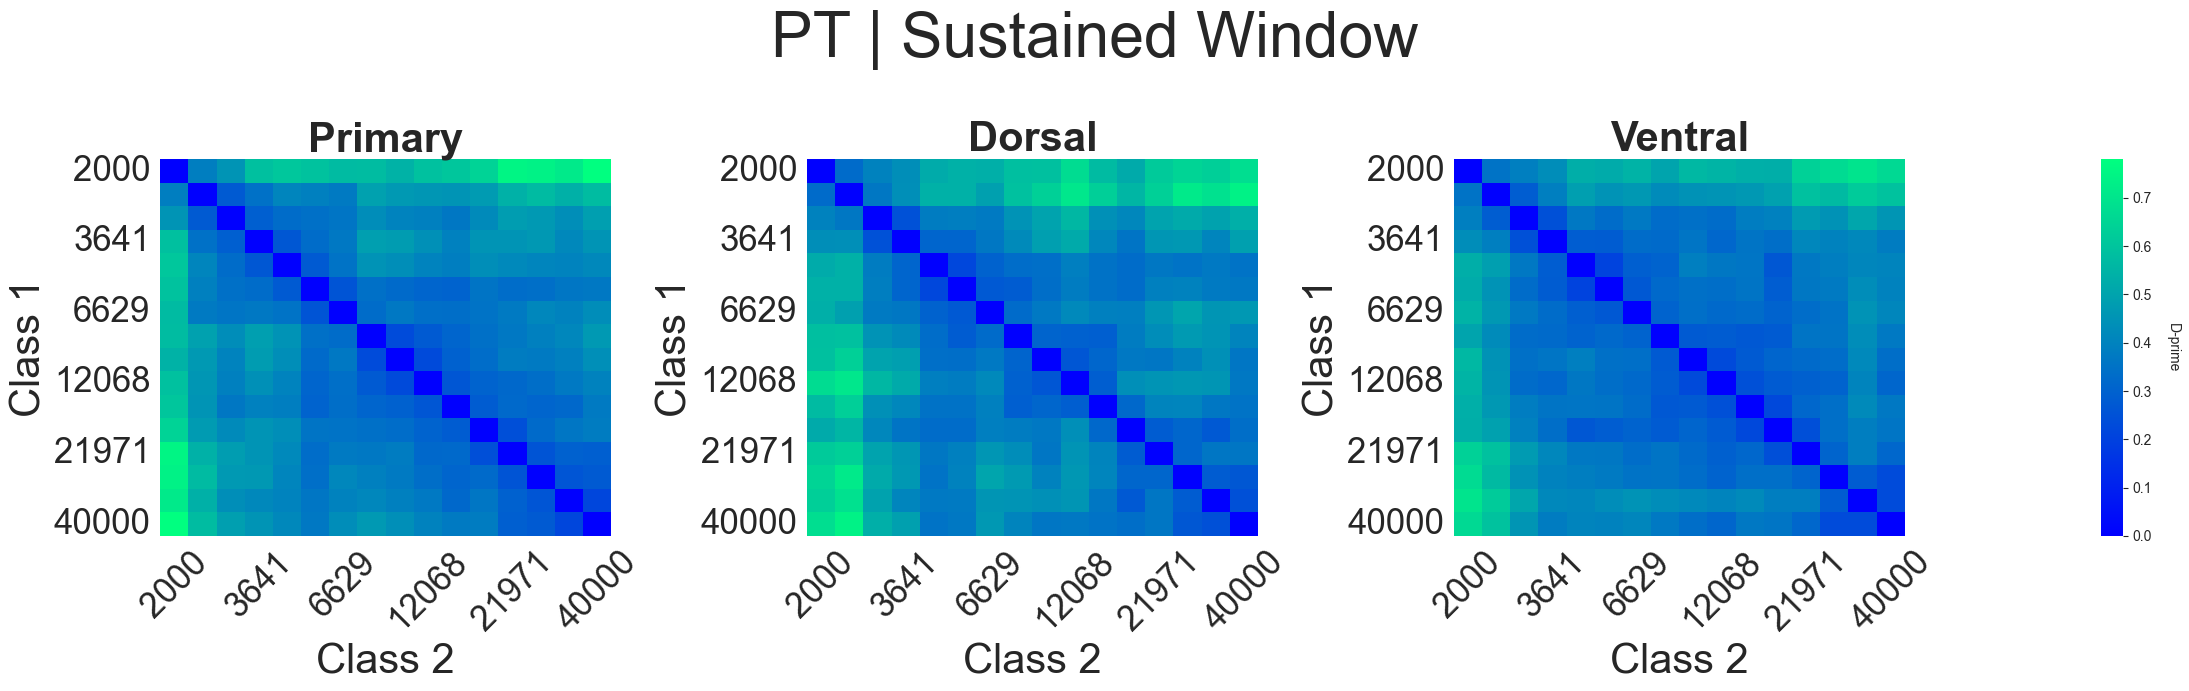

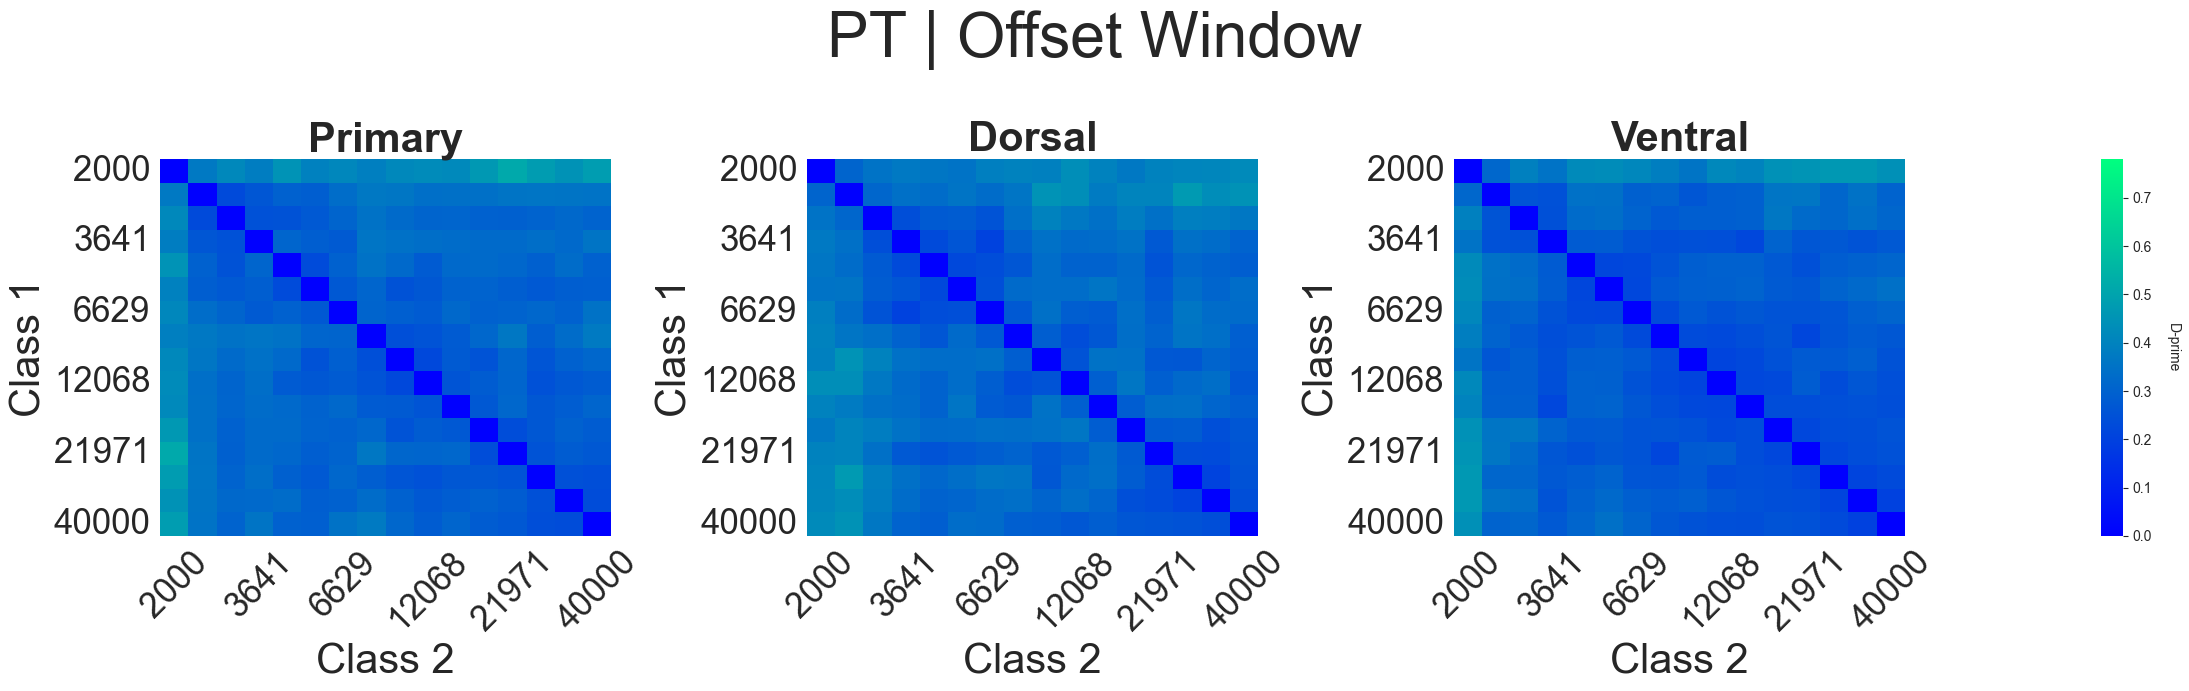

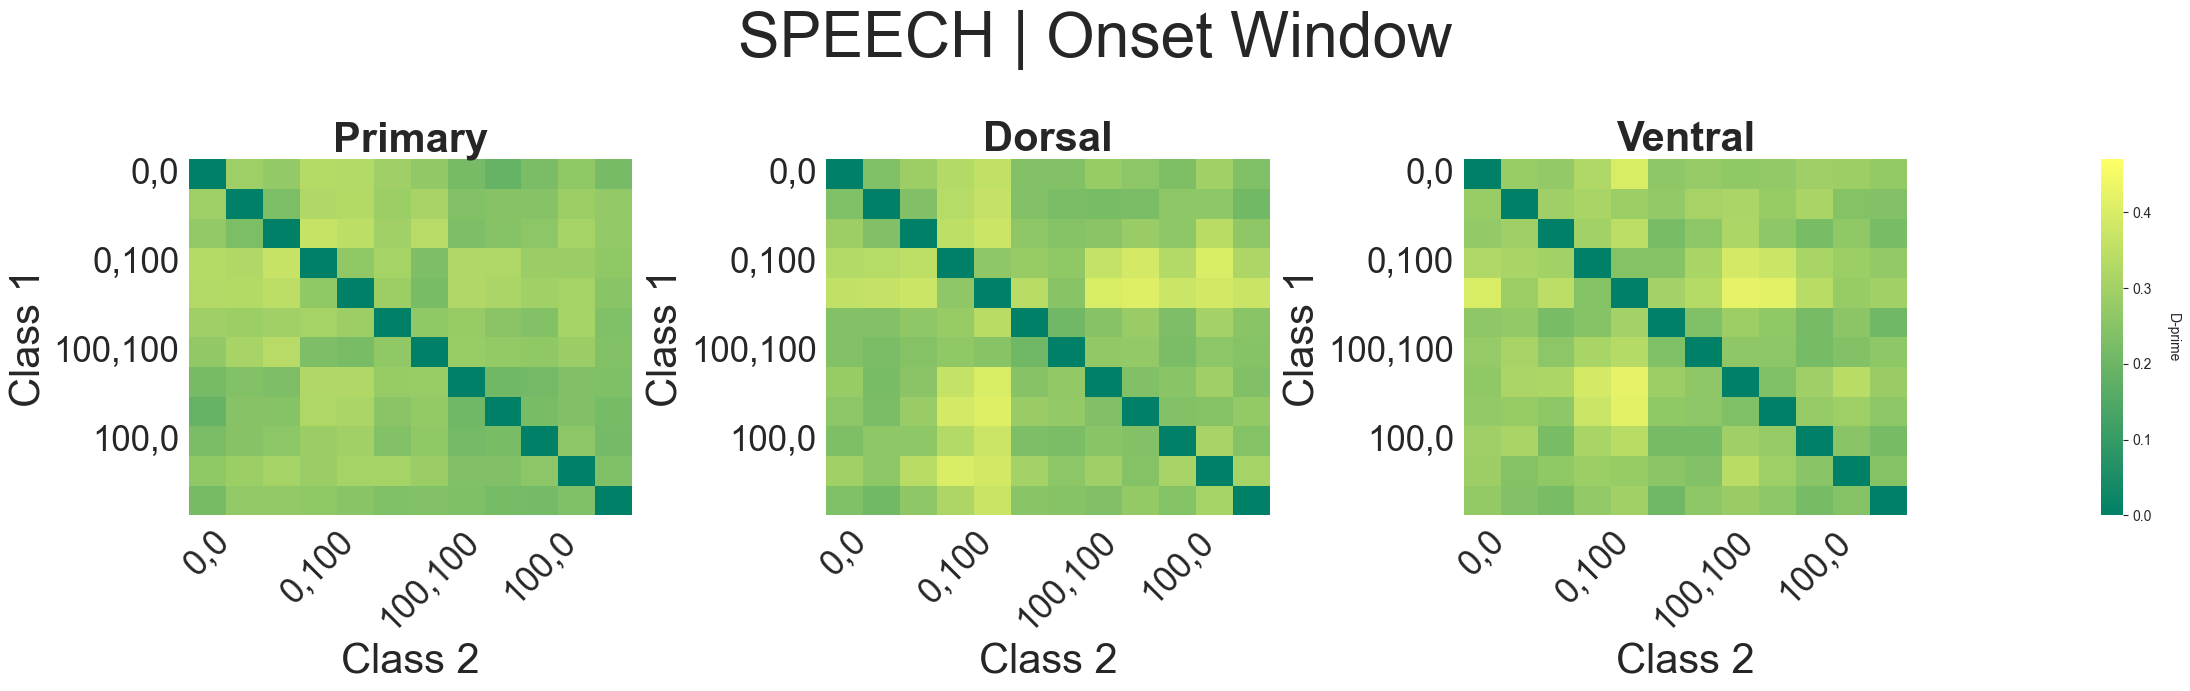

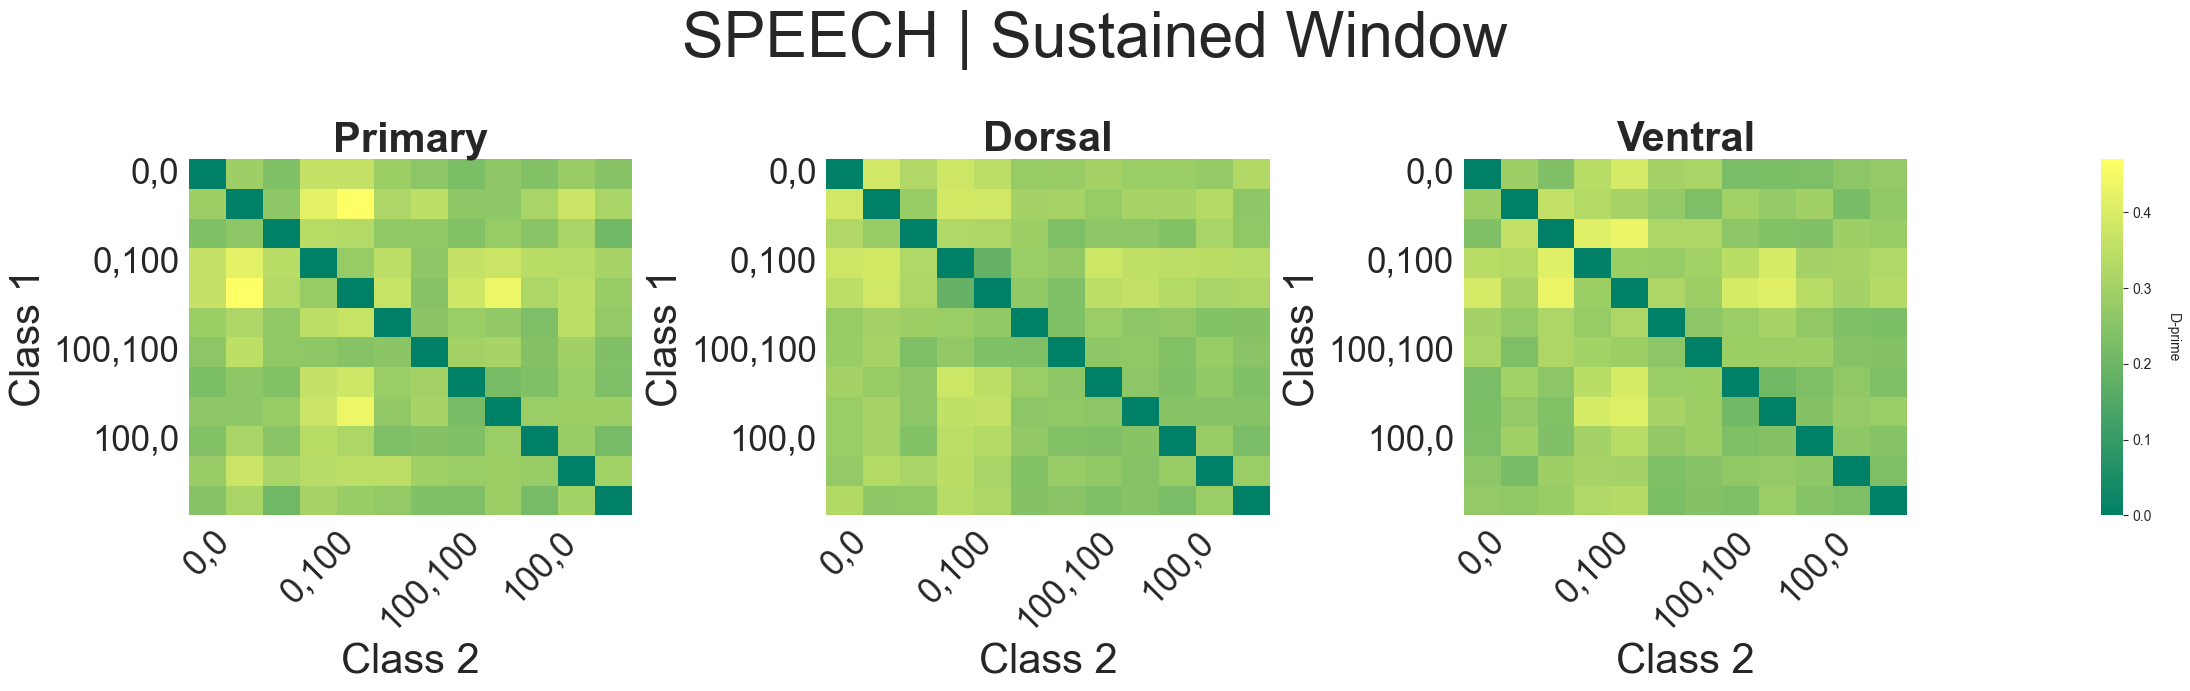

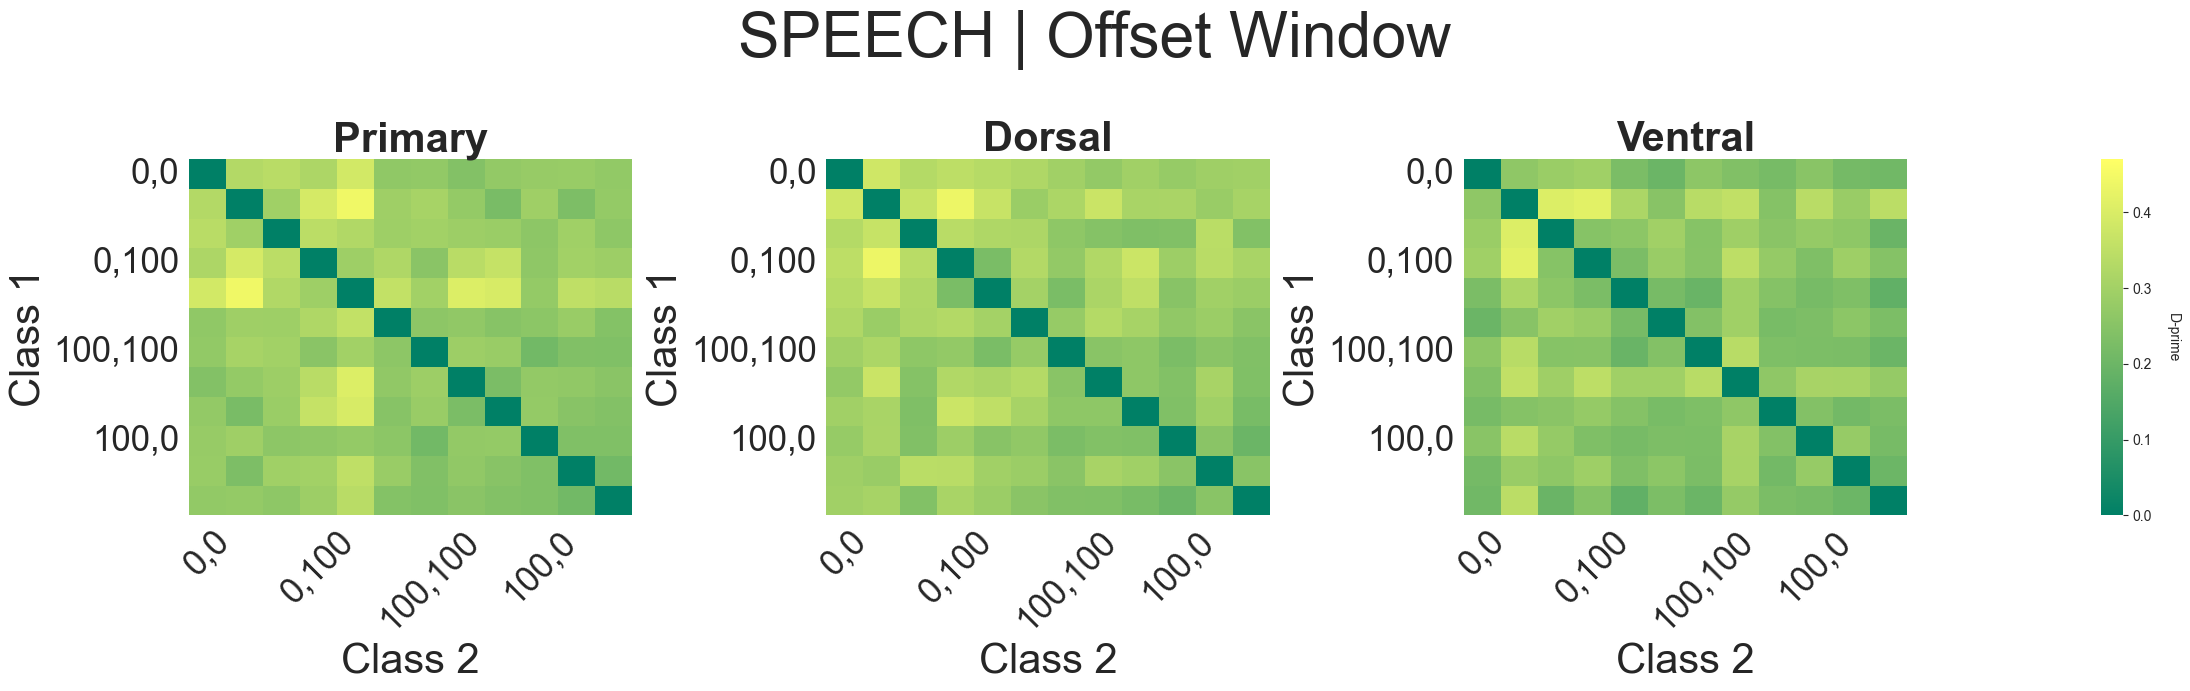

In [35]:
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

save_path = "/Users/zoetomlinson/Desktop/GitHub/neuronalDataResearch/Figures/Population Plots"
dprime_matrices = {}
sound_type_minmax = {}
spike_windows = ['onset', 'sustained', 'offset']
y_max = 0.17

# --- First pass: compute dprime matrices and collect min/max per sound type --- #
for sound_type in ['AM', 'PT', 'speech']:
    dprime_vals = []  # only for this sound_type

    for window_name in spike_windows:
        for brain_area in params.targetSiteNames:
            key = (brain_area, sound_type, window_name)
            if key not in data_dict:
                continue

            X_array = data_dict[key]['X']
            Y_array = data_dict[key]['Y']

            if sound_type == 'speech':
                vot_values = Y_array[:, 0]
                ft_values = Y_array[:, 1]
                unique_freqs = params.unique_labels
            else:
                unique_freqs = sorted(set(Y_array))

            dprime_array = np.zeros((len(unique_freqs), len(unique_freqs)))

            for i, freq1 in enumerate(unique_freqs):
                for j, freq2 in enumerate(unique_freqs):
                    if i == j:
                        continue

                    if sound_type == 'speech':
                        mask_freq1 = (vot_values == freq1[0]) & (ft_values == freq1[1])
                        mask_freq2 = (vot_values == freq2[0]) & (ft_values == freq2[1])
                    else:
                        mask_freq1 = Y_array == freq1
                        mask_freq2 = Y_array == freq2

                    trials_freq1 = X_array[mask_freq1]
                    trials_freq2 = X_array[mask_freq2]

                    if trials_freq1.shape[0] < 1 or trials_freq2.shape[0] < 1:
                        continue

                    avg_freq1 = np.mean(trials_freq1, axis=0)
                    avg_freq2 = np.mean(trials_freq2, axis=0)
                    numerator = np.linalg.norm(avg_freq1 - avg_freq2)

                    distances_freq1 = np.linalg.norm(trials_freq1 - avg_freq1, axis=1)
                    distances_freq2 = np.linalg.norm(trials_freq2 - avg_freq2, axis=1)
                    denominator = (np.sum(distances_freq1) + np.sum(distances_freq2)) / (len(distances_freq1) + len(distances_freq2))

                    dprime = numerator / denominator if denominator != 0 else 0
                    dprime_array[i, j] = dprime

            dprime_matrices[key] = dprime_array
            dprime_vals.append(dprime_array.flatten())

    # Store global min/max for this sound type
    dprime_vals = np.concatenate(dprime_vals)
    sound_type_minmax[sound_type] = (np.min(dprime_vals), np.max(dprime_vals))

# --- Second pass: generate plots with per-sound-type vmin/vmax --- #
for sound_type in ['AM', 'PT', 'speech']:
    global_min, global_max = sound_type_minmax[sound_type]

    for window_name in spike_windows:
        fig = plt.figure(figsize=(22, 7))
        fig.suptitle(f"{sound_type.upper()} | {window_name.capitalize()} Window", fontsize=45)
        gs = gridspec.GridSpec(1, len(params.targetSiteNames) + 1, width_ratios=[1]*len(params.targetSiteNames) + [0.05])
        axs = [fig.add_subplot(gs[i]) for i in range(len(params.targetSiteNames))]
        cbar_ax = fig.add_subplot(gs[-1])

        for idx, brain_area in enumerate(params.targetSiteNames):
            key = (brain_area, sound_type, window_name)
            if key not in dprime_matrices:
                continue

            dprime_array = dprime_matrices[key]

            if sound_type == 'speech':
                all_labels = [f"{vot},{ft}" for vot, ft in params.unique_labels]
                label_mask = np.arange(len(all_labels)) % 3 == 0
            else:
                all_freqs = sorted(set(data_dict[key]['Y']))
                all_labels = [str(int(round(val))) for val in all_freqs]
                label_mask = np.arange(len(all_labels)) % 3 == 0

            x_labels = [label if show else "" for label, show in zip(all_labels, label_mask)]
            y_labels = [label if show else "" for label, show in zip(all_labels, label_mask)]

            sns.heatmap(dprime_array,
                        cmap=params.sound_colormaps[sound_type],
                        vmin=global_min,
                        vmax=global_max,
                        xticklabels=x_labels,
                        yticklabels=y_labels,
                        ax=axs[idx],
                        cbar=(idx == 0),
                        cbar_ax=cbar_ax if idx == 0 else None)

            axs[idx].set_xlabel("Class 2", size=30)
            axs[idx].set_ylabel("Class 1", size=30)
            axs[idx].tick_params(axis='x', labelsize=25, rotation=45)
            axs[idx].tick_params(axis='y', labelsize=25, rotation=0)
            axs[idx].set_title(params.short_names.get(brain_area, brain_area), fontsize=30, fontweight="bold")

        cbar_ax.set_ylabel('D-prime', rotation=270, labelpad=20)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        filename = f"{sound_type}_{window_name}_dprime_heatmaps.png"
        plt.savefig(os.path.join(save_path, filename), bbox_inches='tight')

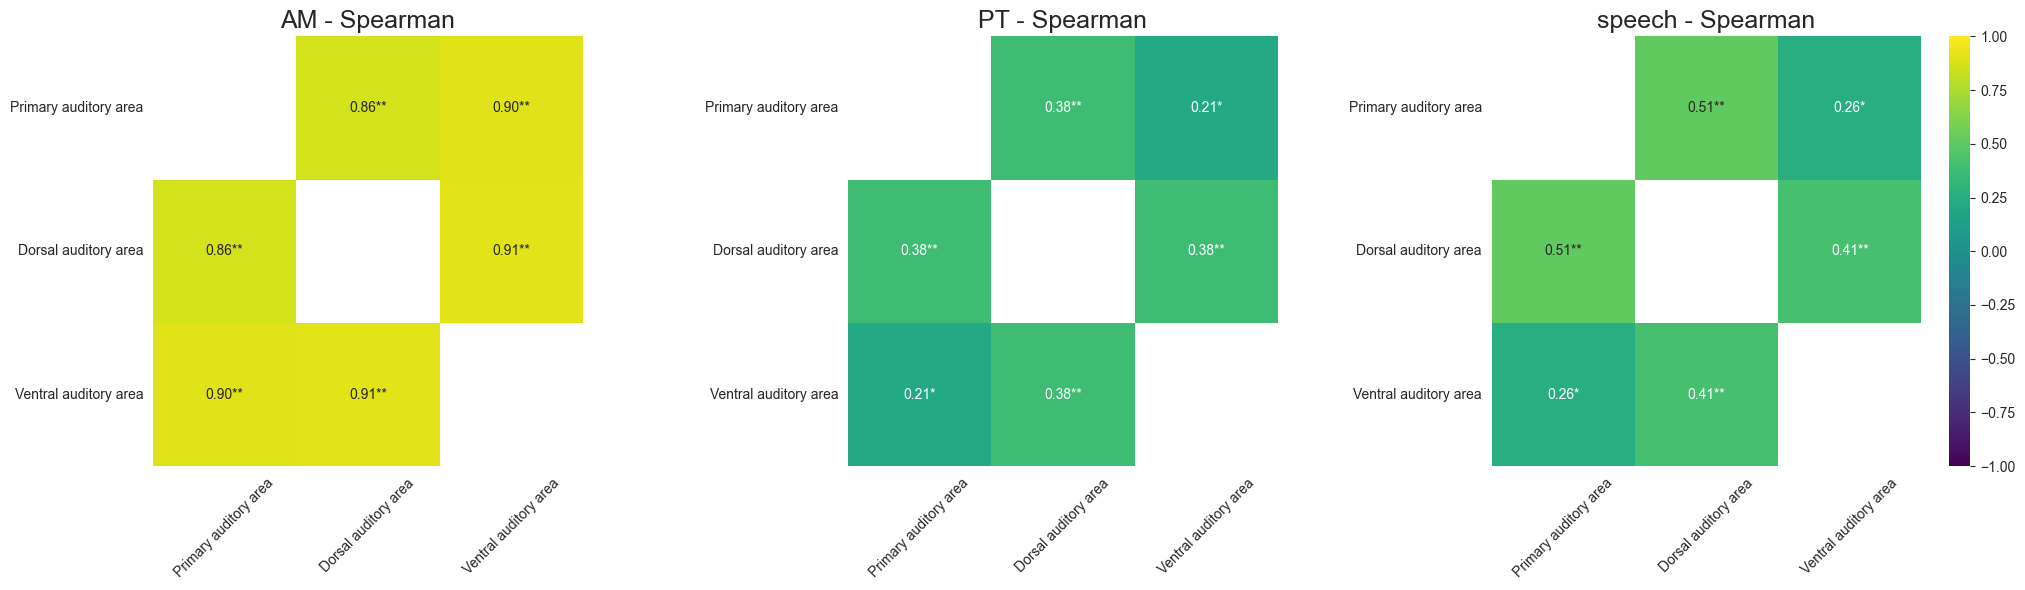

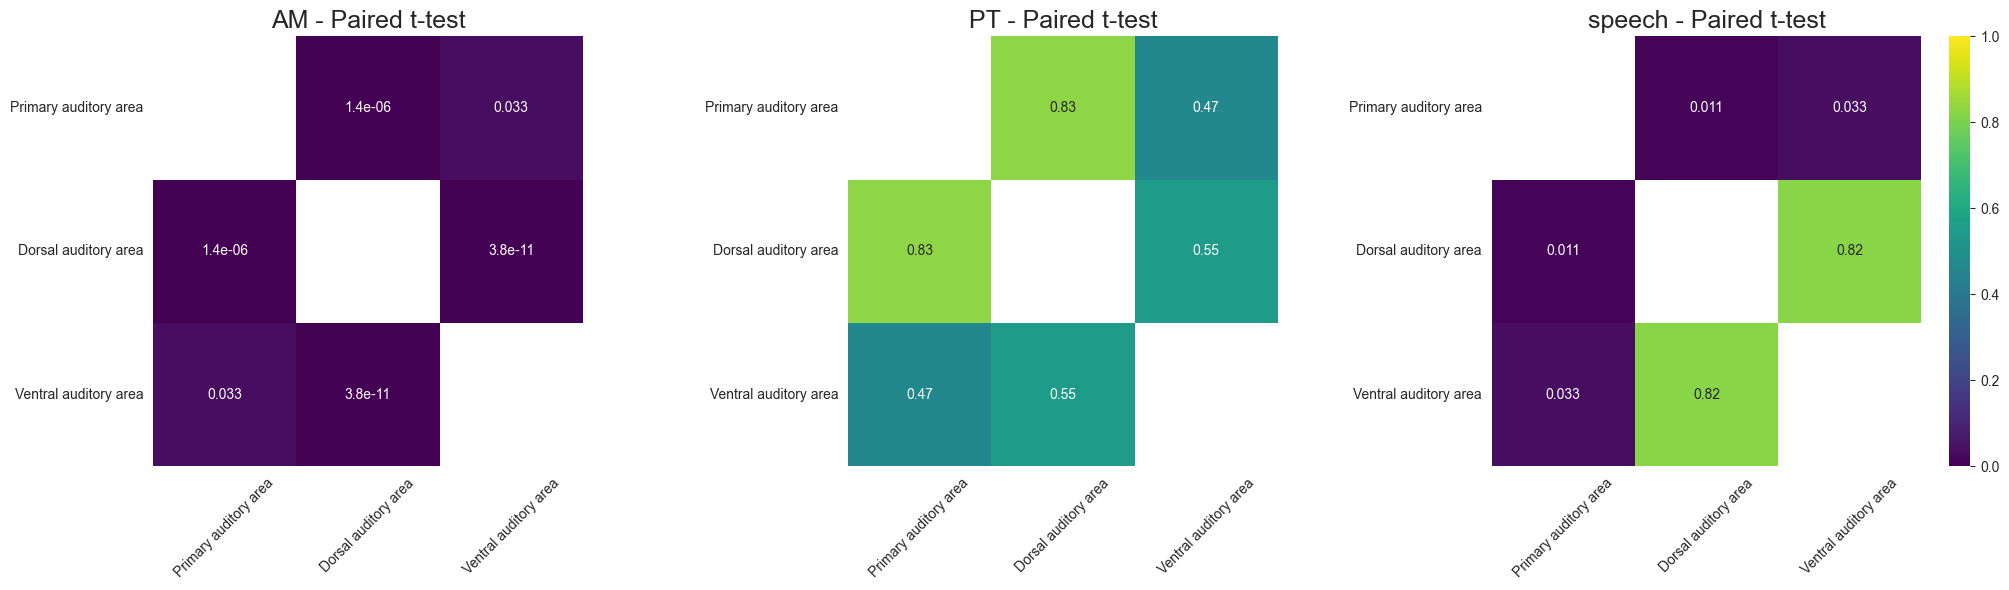

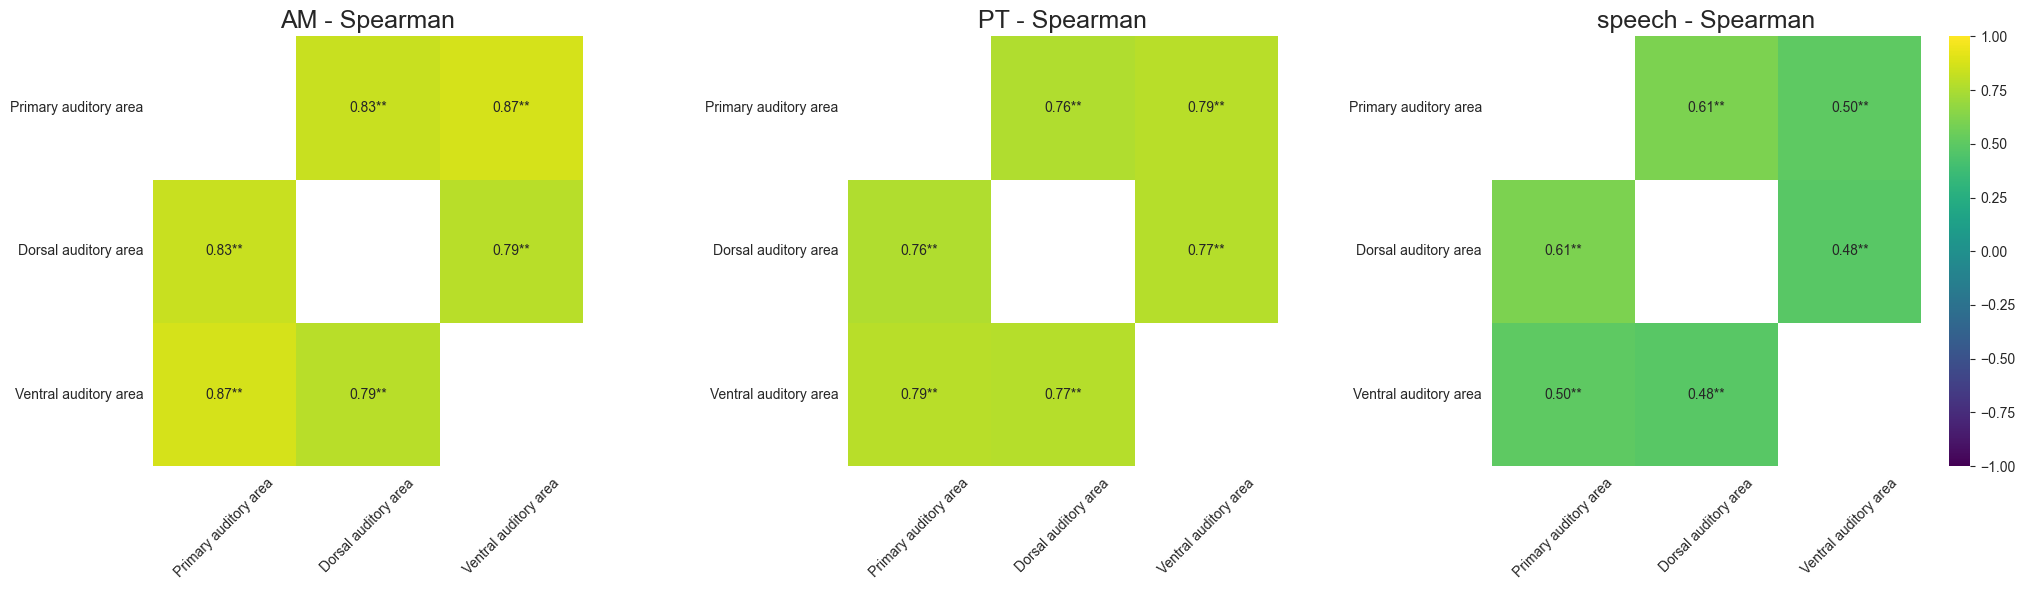

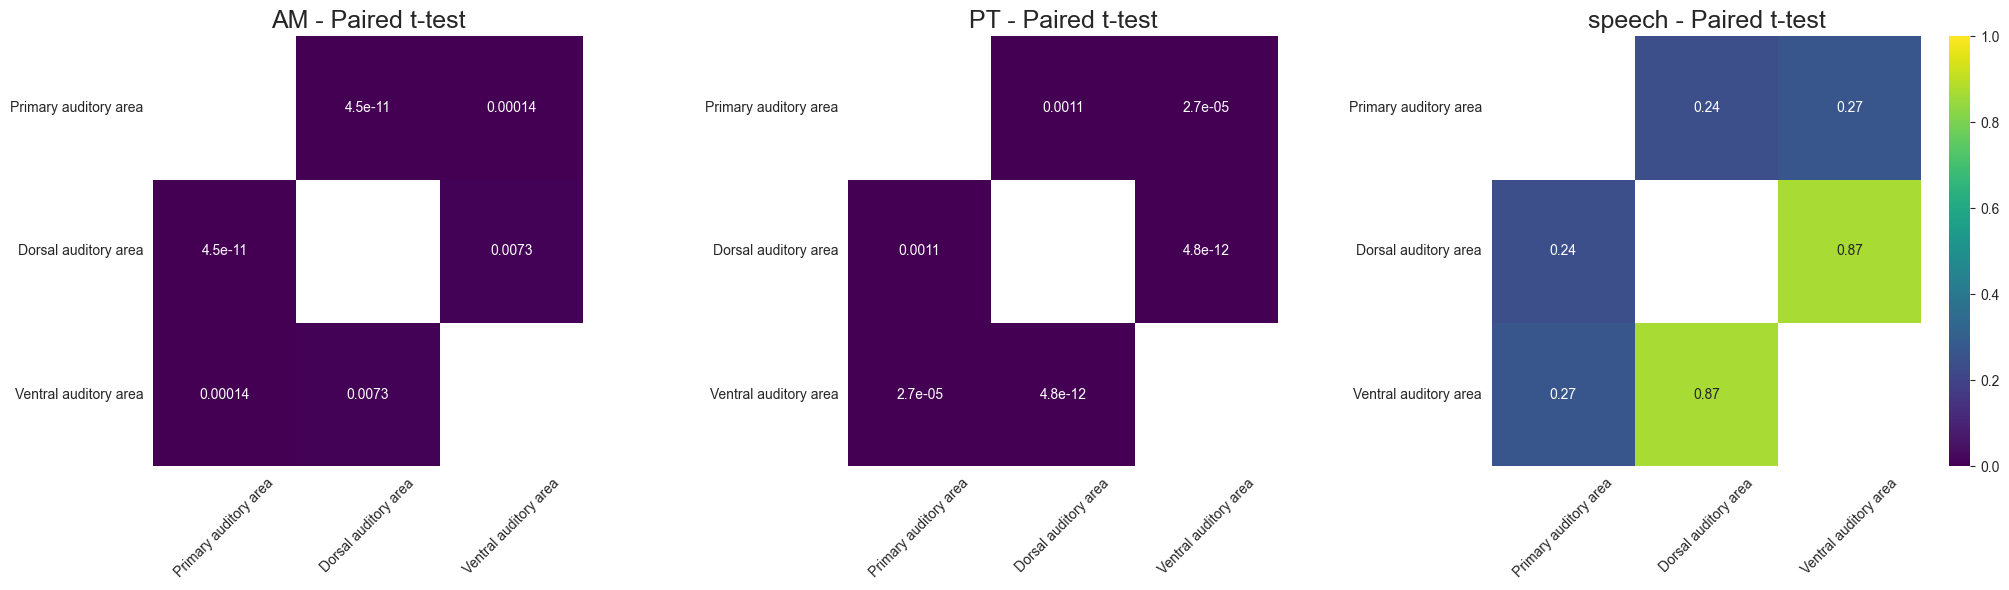

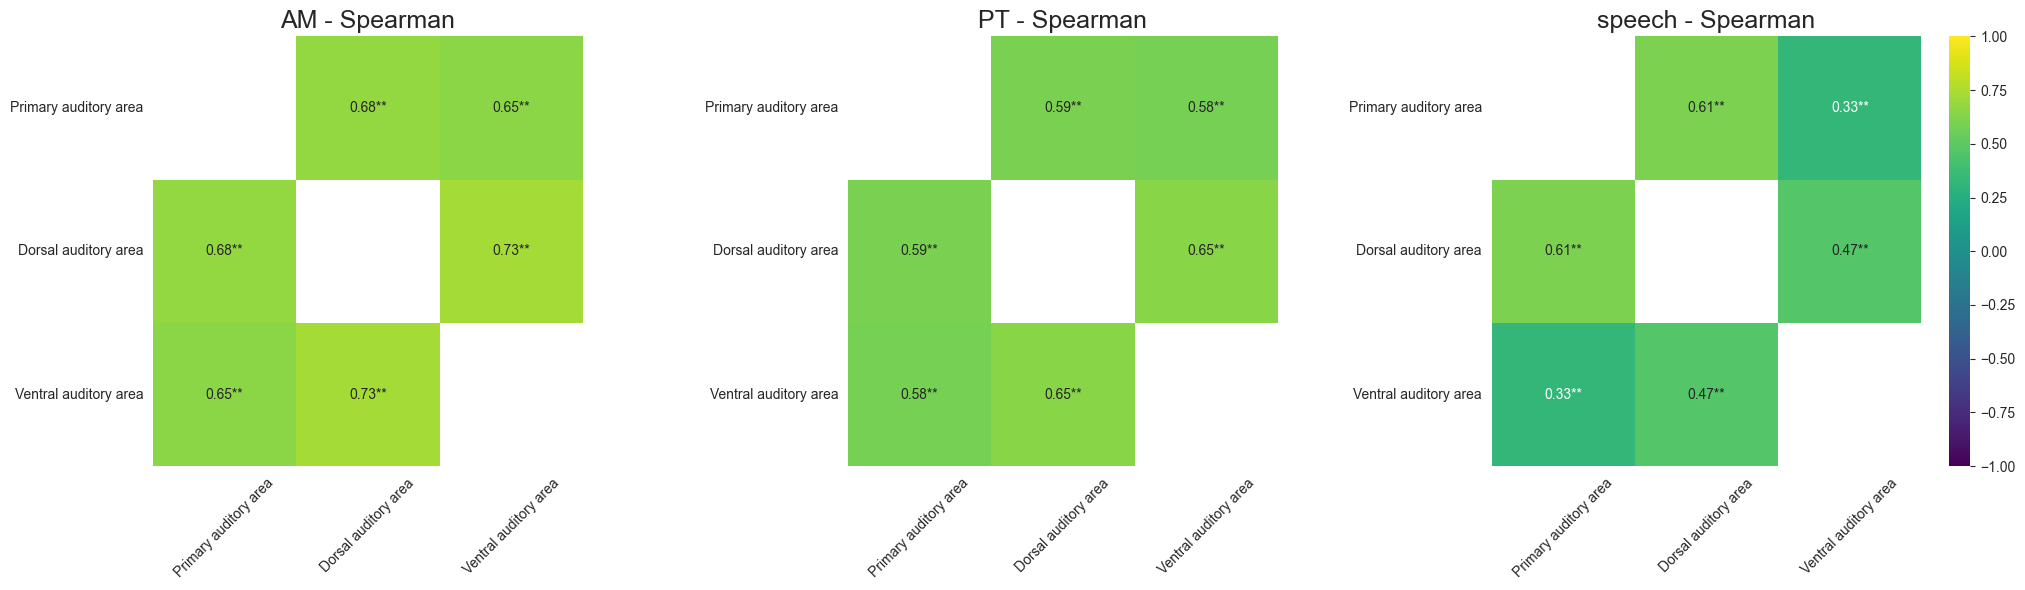

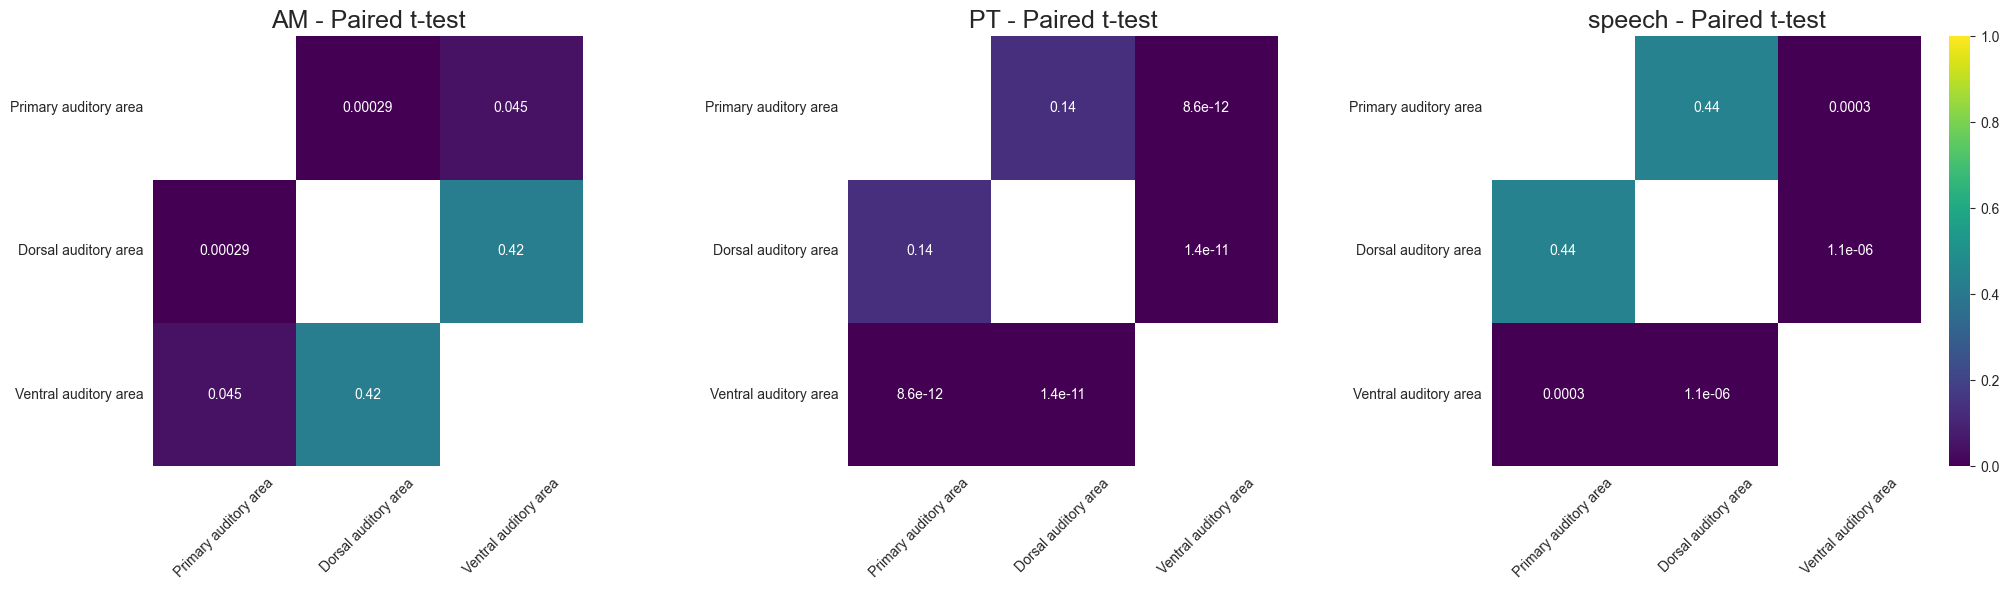

In [30]:
import pandas as pd
from scipy.stats import spearmanr, ttest_rel
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

significant_pairs = []
sound_types = ['AM', 'PT', 'speech']
areas = params.targetSiteNames
spike_windows = ['onset', 'sustained', 'offset']

for window_name in spike_windows:
    fig_corr, axs_corr = plt.subplots(1, 3, figsize=(21, 6))
    fig_pval, axs_pval = plt.subplots(1, 3, figsize=(21, 6))

    for idx, sound_type in enumerate(sound_types):
        n_areas = len(areas)

        # Initialize correlation and p-value matrices
        corr_matrix = pd.DataFrame(np.nan, index=areas, columns=areas)
        pval_matrix = pd.DataFrame(np.nan, index=areas, columns=areas)
        annot_matrix = pd.DataFrame('', index=areas, columns=areas)

        combos = list(itertools.combinations(areas, 2))
        for brain1, brain2 in combos:
            key1 = (brain1, sound_type, window_name)
            key2 = (brain2, sound_type, window_name)

            matrix1 = dprime_matrices.get(key1)
            matrix2 = dprime_matrices.get(key2)

            if matrix1 is None or matrix2 is None or matrix1.shape != matrix2.shape:
                print(f"Skipping {brain1} vs {brain2} for {sound_type} ({window_name}) due to shape mismatch.")
                continue

            # Take only upper triangle excluding diagonal
            mask = np.triu(np.ones(matrix1.shape), k=1).astype(bool)
            flat1 = matrix1[mask]
            flat2 = matrix2[mask]

            # Spearman and paired t-test
            rho, spearman_p = spearmanr(flat1, flat2)
            t_stat, ttest_p = ttest_rel(flat1, flat2)

            if ttest_p < 0.05:
                significant_pairs.append((window_name, sound_type, brain1, brain2))

            # Fill matrices
            corr_matrix.loc[brain1, brain2] = corr_matrix.loc[brain2, brain1] = rho
            pval_matrix.loc[brain1, brain2] = pval_matrix.loc[brain2, brain1] = ttest_p

            # Annotate Spearman with stars
            stars = '**' if spearman_p < 0.01 else '*' if spearman_p < 0.05 else ''
            text = f"{rho:.2f}{stars}"
            annot_matrix.loc[brain1, brain2] = annot_matrix.loc[brain2, brain1] = text

        # Plot Spearman correlation matrix
        sns.heatmap(
            corr_matrix.astype(float),
            annot=annot_matrix.values,
            fmt='',
            cmap='viridis',
            vmin=-1,
            vmax=1,
            square=True,
            ax=axs_corr[idx],
            cbar=(idx == len(sound_types) - 1)
        )

        axs_corr[idx].set_title(f"{sound_type} - Spearman", fontsize=18)
        axs_corr[idx].tick_params(axis='x', rotation=45)
        axs_corr[idx].tick_params(axis='y', rotation=0)

        # Plot Paired t-test p-values matrix
        sns.heatmap(
            pval_matrix.astype(float),
            annot=True,
            cmap='viridis',
            vmin=0,
            vmax=1,
            square=True,
            ax=axs_pval[idx],
            cbar=(idx == len(sound_types) - 1)
        )

        # White-out diagonal
        for i in range(n_areas):
            axs_corr[idx].add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='white', lw=0))
            axs_pval[idx].add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='white', lw=0))

        axs_pval[idx].set_title(f"{sound_type} - Paired t-test", fontsize=18)
        axs_pval[idx].tick_params(axis='x', rotation=45)
        axs_pval[idx].tick_params(axis='y', rotation=0)

    fig_corr.tight_layout()
    fig_pval.tight_layout()

    # Save per spike window
    fig_corr.savefig(os.path.join(save_path, f"{window_name}_spearman_heatmaps.png"))
    fig_pval.savefig(os.path.join(save_path, f"{window_name}_ttest_pval_heatmaps.png"))

/var/folders/l9/v78y7h896278tzntj74hkdkr0000gn/T/ipykernel_66880/533365217.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sound_order, fontsize=25)


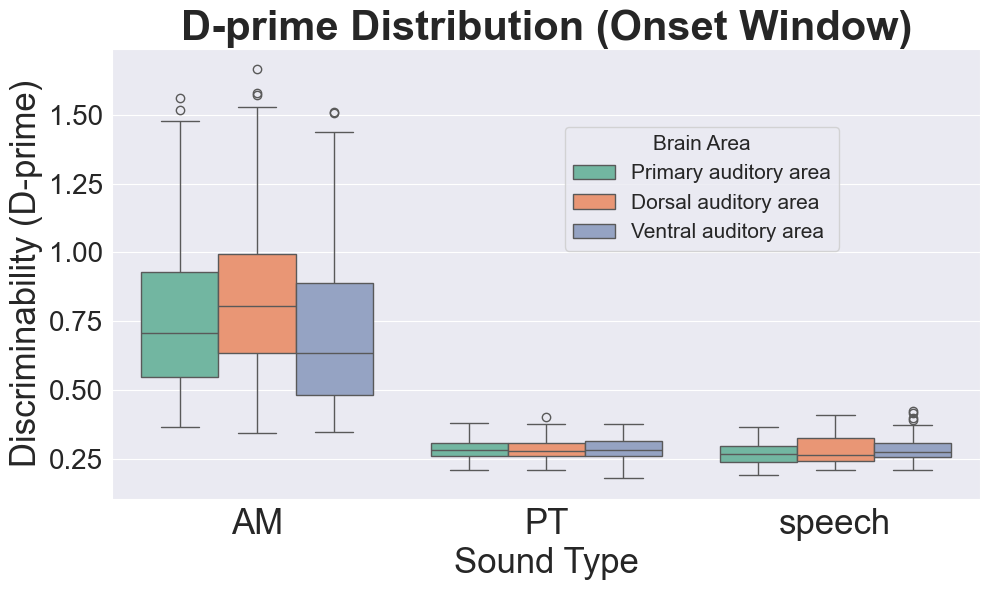

/var/folders/l9/v78y7h896278tzntj74hkdkr0000gn/T/ipykernel_66880/533365217.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sound_order, fontsize=25)


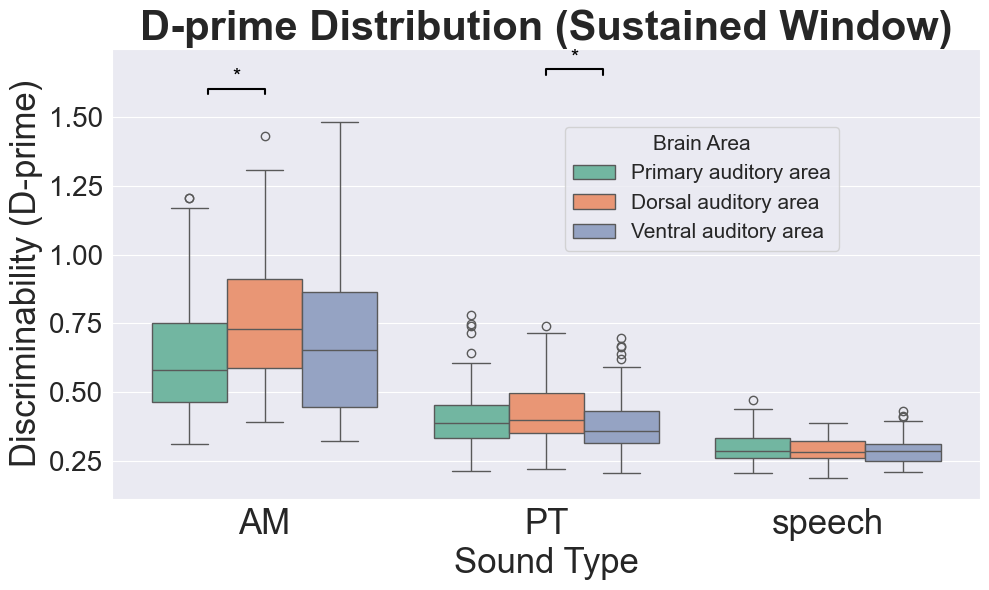

/var/folders/l9/v78y7h896278tzntj74hkdkr0000gn/T/ipykernel_66880/533365217.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sound_order, fontsize=25)


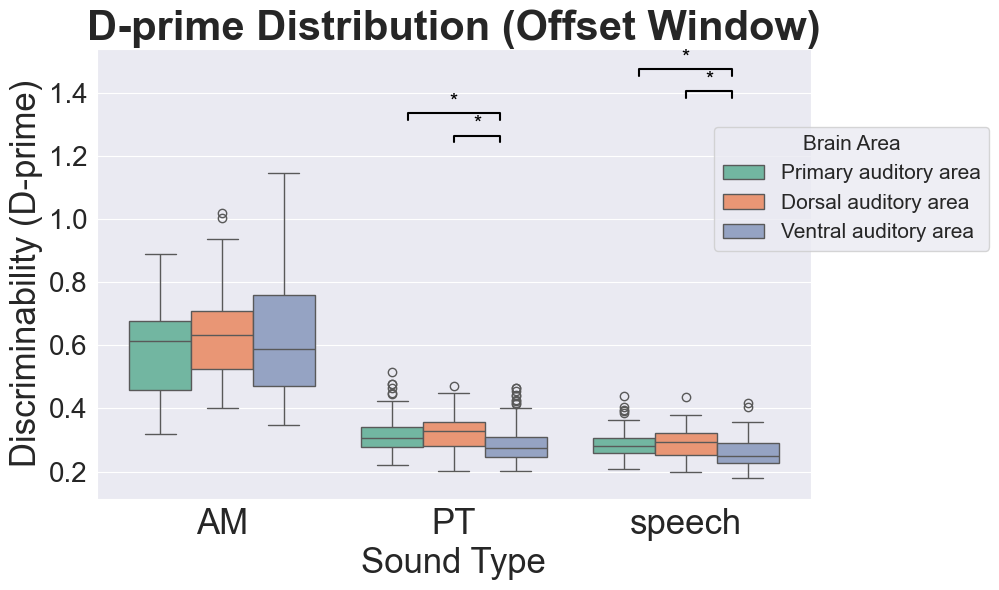

In [31]:
from scipy.stats import f_oneway
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

spike_windows = ['onset', 'sustained', 'offset']
sound_order = ['AM', 'PT', 'speech']  # or however you're ordering

for window_name in spike_windows:
    significant_pairs = []

    # Construct dprime_df for this window
    all_rows = []
    for (brain_area, sound_type, win), matrix in dprime_matrices.items():
        if win != window_name:
            continue

        if sound_type == 'speech':
            label_list = params.unique_labels
        else:
            Y_vals = data_dict[(brain_area, sound_type, window_name)]['Y']
            label_list = sorted(set(Y_vals))

        # Get upper triangle only
        mask = np.triu(np.ones(matrix.shape), k=1).astype(bool)
        values = matrix[mask]

        for val in values:
            all_rows.append({
                'D-prime': val,
                'Sound': sound_type,
                'Brain Area': brain_area,
                'Spike Window': window_name
            })

    dprime_df = pd.DataFrame(all_rows)

    # --- ANOVA + Tukey ---
    for sound_type in sound_order:
        group_data = [
            dprime_df[(dprime_df['Sound'] == sound_type) & (dprime_df['Brain Area'] == area)]['D-prime']
            for area in areas
        ]

        f_stat, p_anova = f_oneway(*group_data)

        if p_anova < 0.05:
            subset_df = dprime_df[dprime_df['Sound'] == sound_type]
            tukey = pairwise_tukeyhsd(endog=subset_df['D-prime'],
                                      groups=subset_df['Brain Area'],
                                      alpha=0.05)

            for result in tukey.summary().data[1:]:
                area1, area2, _, _, _, p_adj, reject = result
                if reject:
                    significant_pairs.append((sound_type, area1, area2))

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(
        data=dprime_df,
        x='Sound',
        y='D-prime',
        hue='Brain Area',
        hue_order=areas,
        palette='Set2',
        ax=ax
    )

    plt.title(f'D-prime Distribution ({window_name.capitalize()} Window)', fontweight='bold', fontsize=30)

    # Offset logic for significance stars
    box_offsets = {area: i * 0.2 - 0.2 for i, area in enumerate(areas)}
    stack_base_y = dprime_df['D-prime'].max() + 0.1
    stack_height = 0.07
    stack_counter = 0

    for sound, area1, area2 in significant_pairs:
        if area1 not in areas or area2 not in areas:
            continue

        x = sound_order.index(sound)
        x1 = x + box_offsets[area1]
        x2 = x + box_offsets[area2]

        y = stack_base_y + stack_counter * stack_height

        ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1.5, c='k')
        ax.text((x1 + x2) / 2, y + 0.025, '*', ha='center', va='bottom', color='k', fontsize=15)
        stack_counter += 1

    ax.set_ylabel('Discriminability (D-prime)', fontsize=25)
    ax.set_xlabel("Sound Type", fontsize=25)
    ax.set_xticklabels(sound_order, fontsize=25)
    ax.tick_params(axis='y', labelsize=20)

    legend = ax.legend(title='Brain Area', title_fontsize=15, fontsize=15, bbox_to_anchor=(0.85, 0.85))

    plt.tight_layout()
    filename = f"boxplot_dprime_by_sound_and_area_{window_name}.png"
    plt.savefig(os.path.join(save_path, filename))
    plt.show()

## LDA Discriminability Analysis

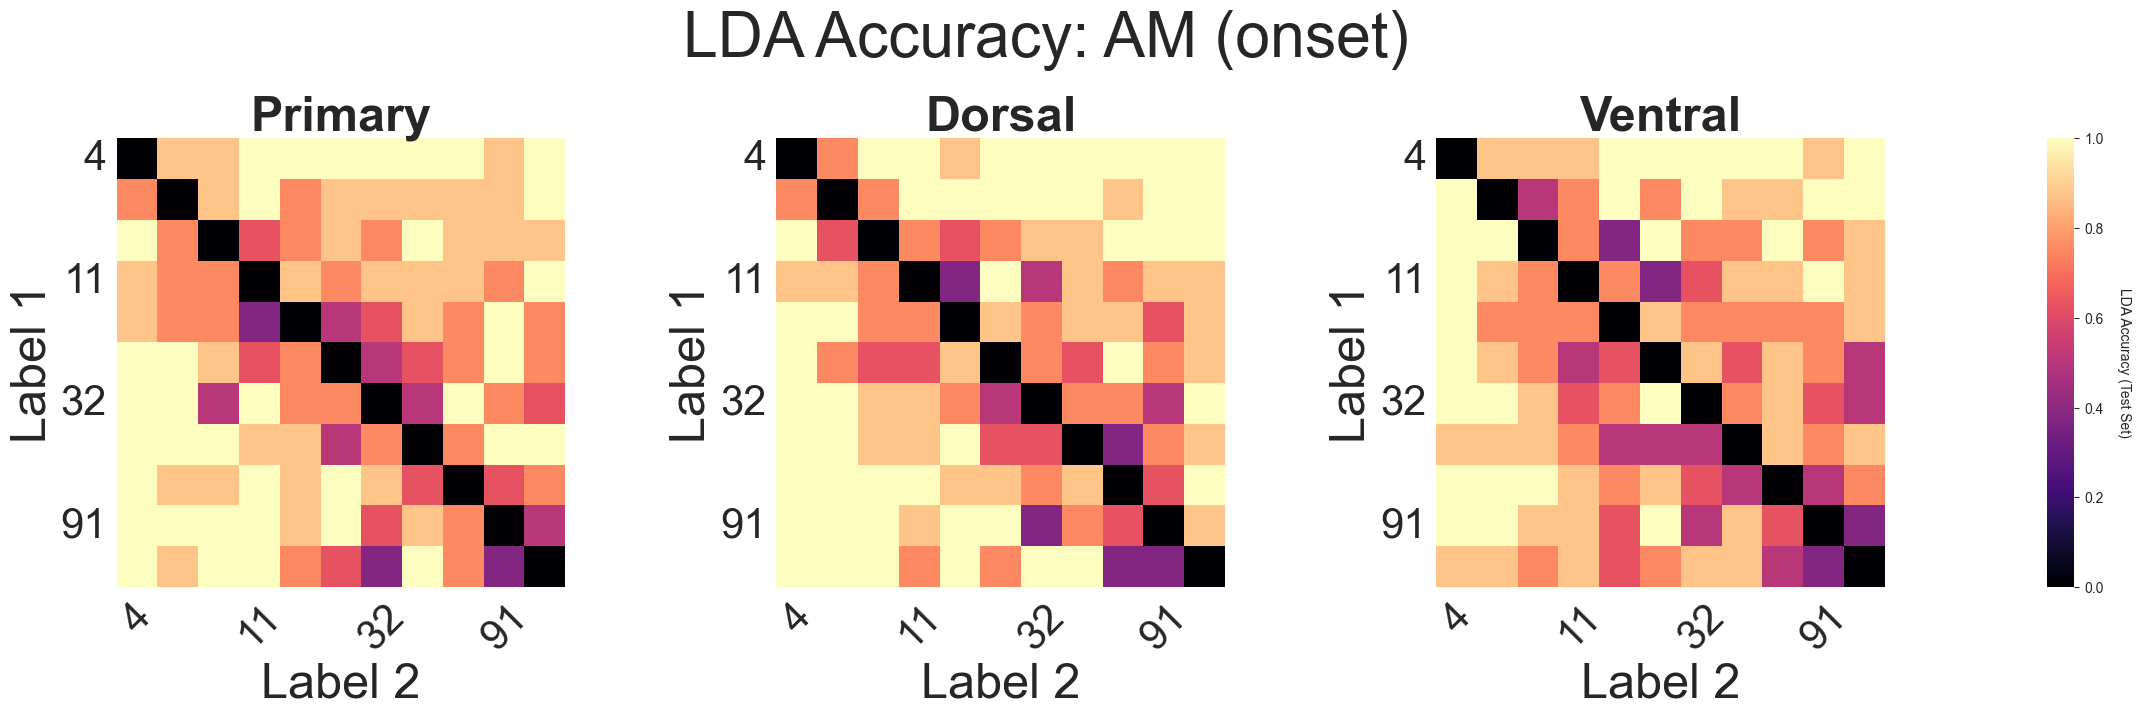

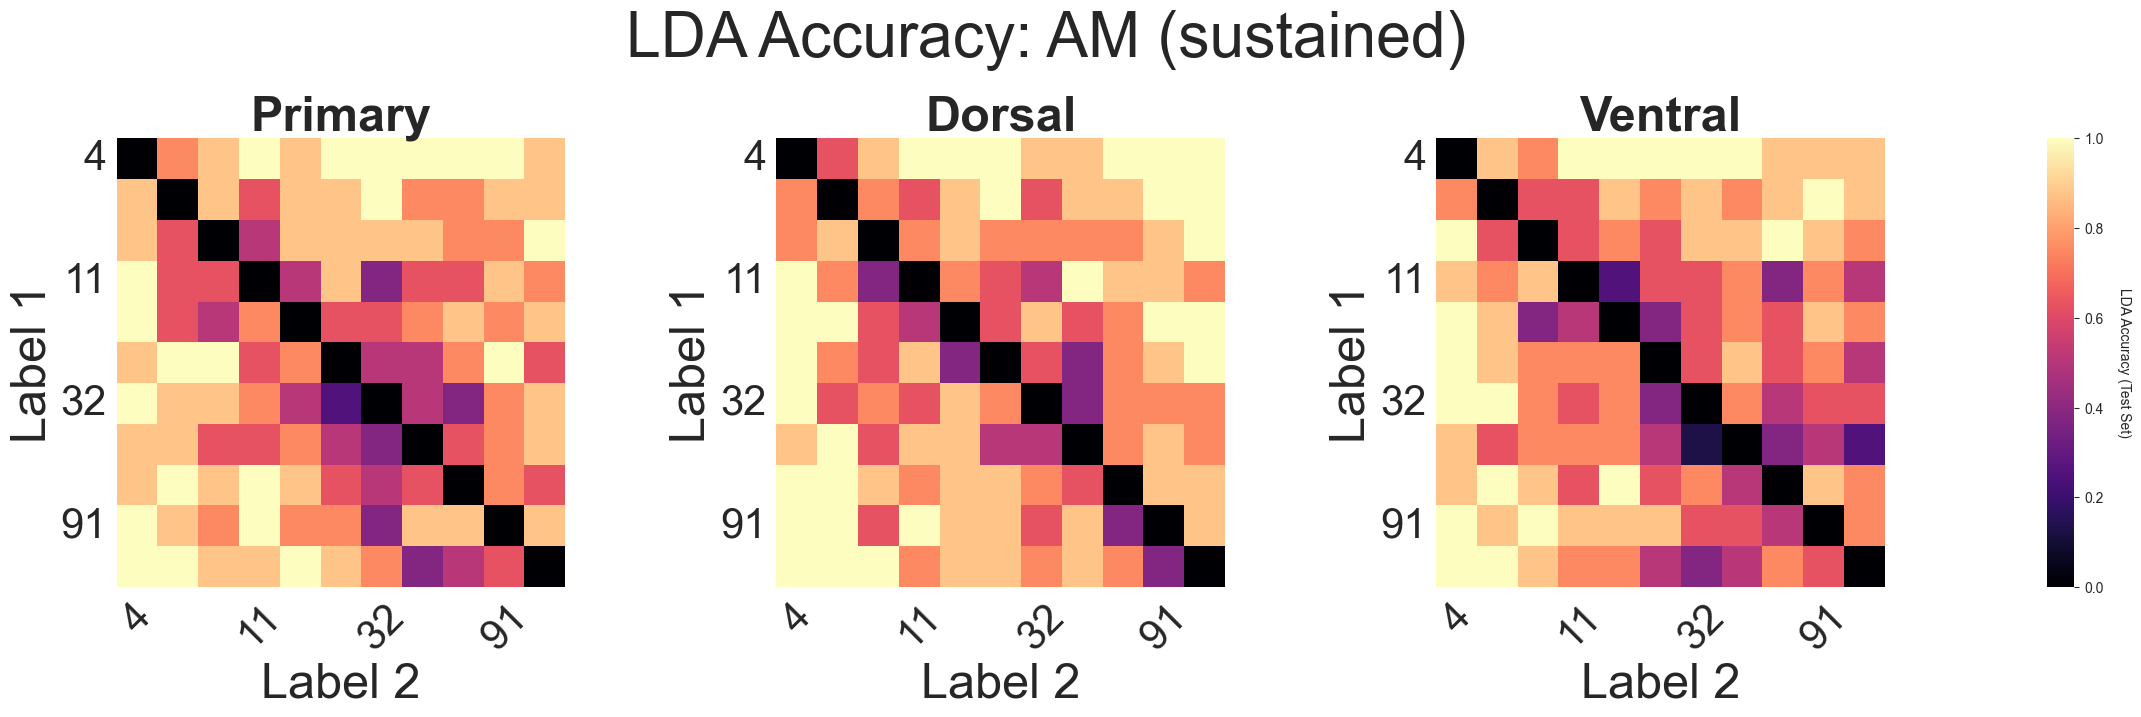

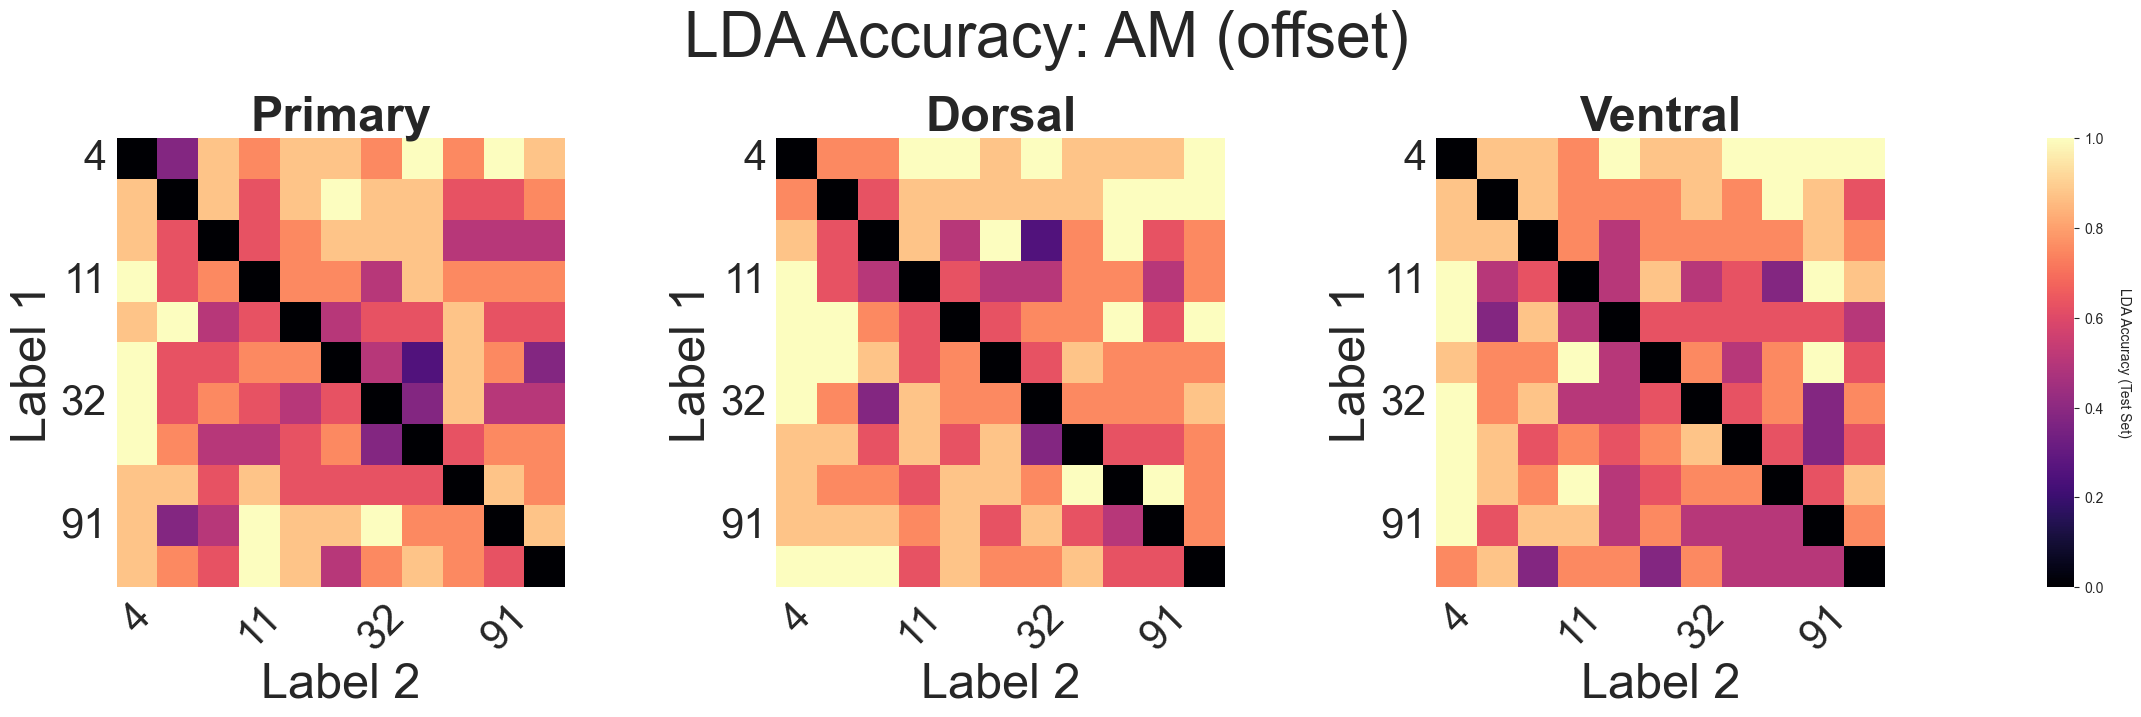

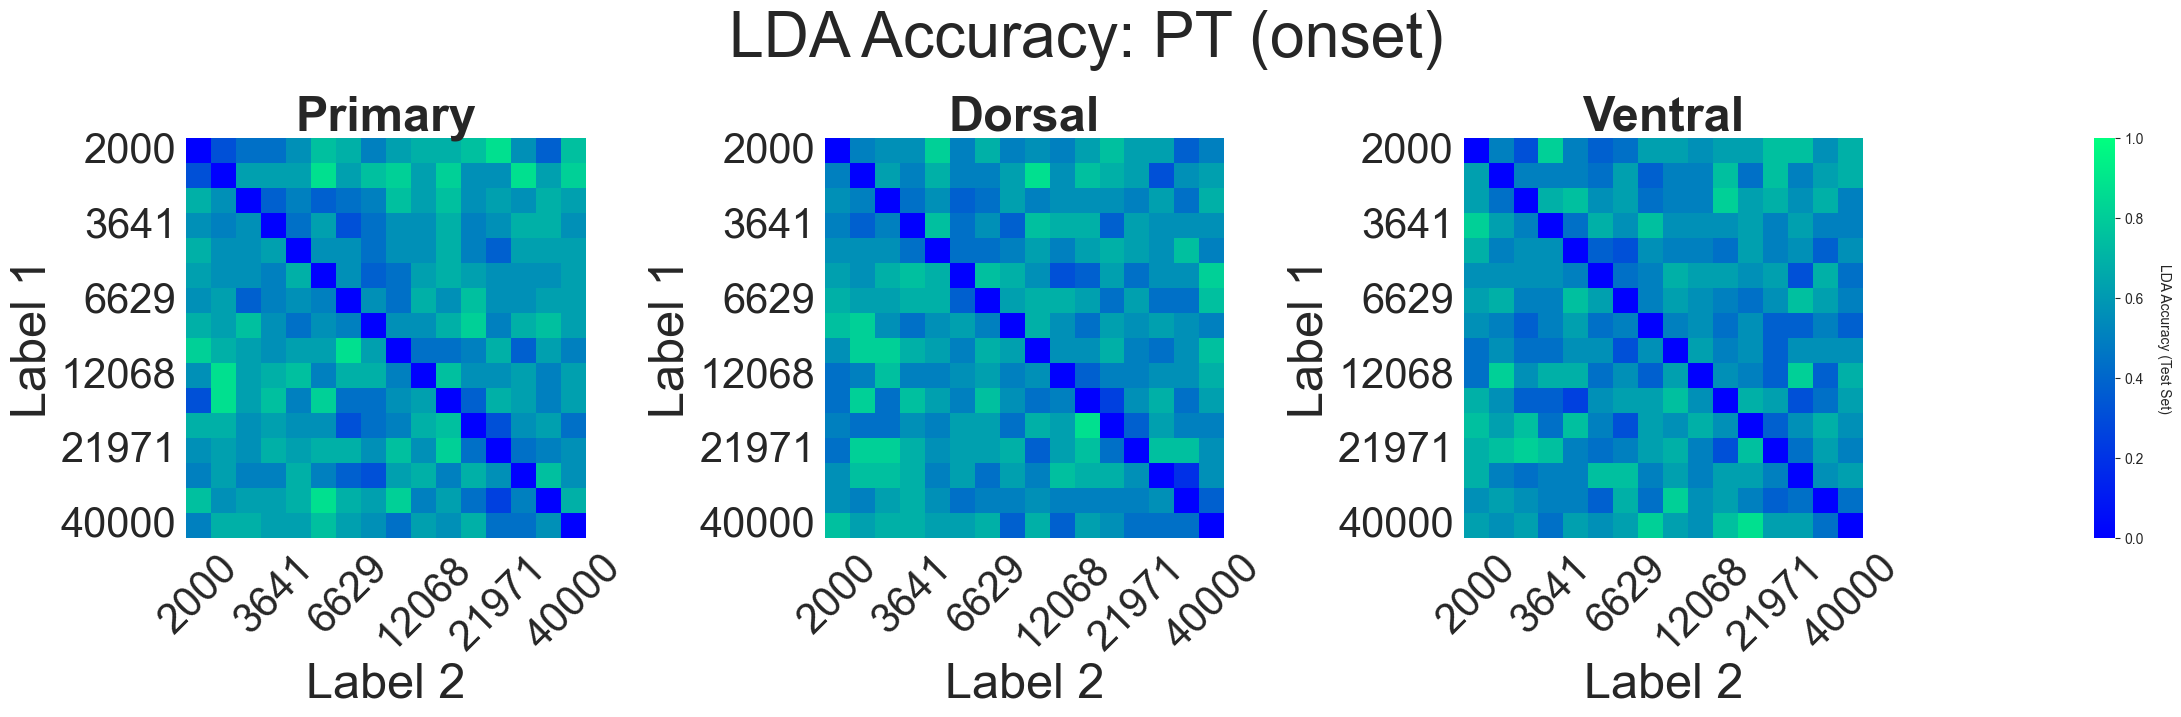

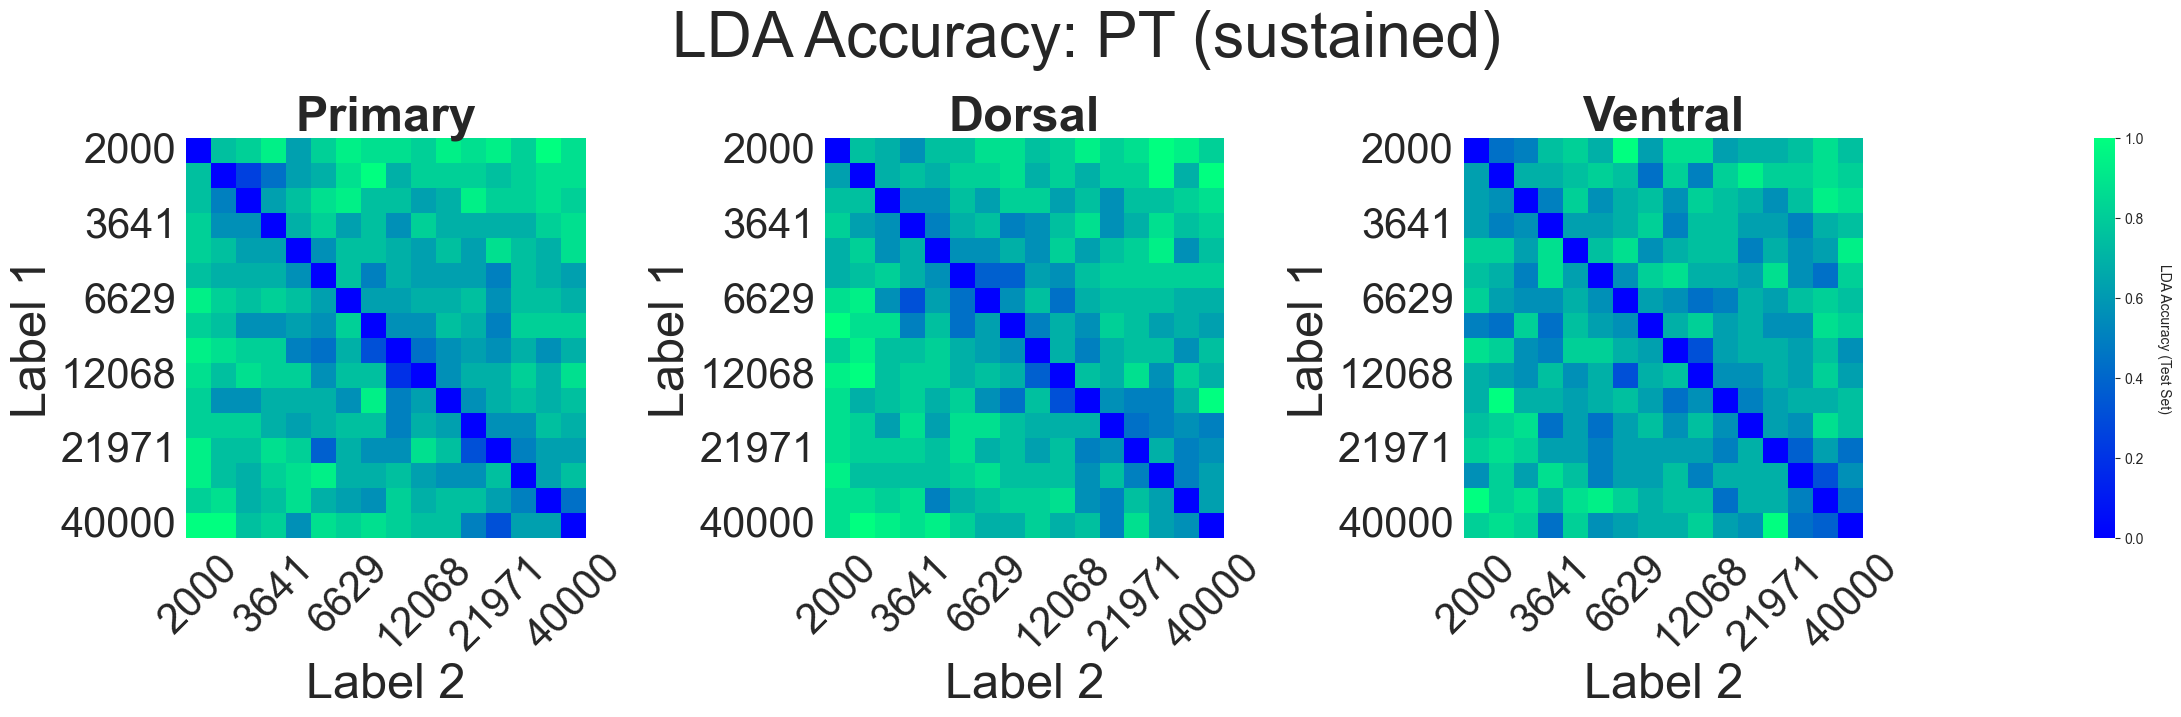

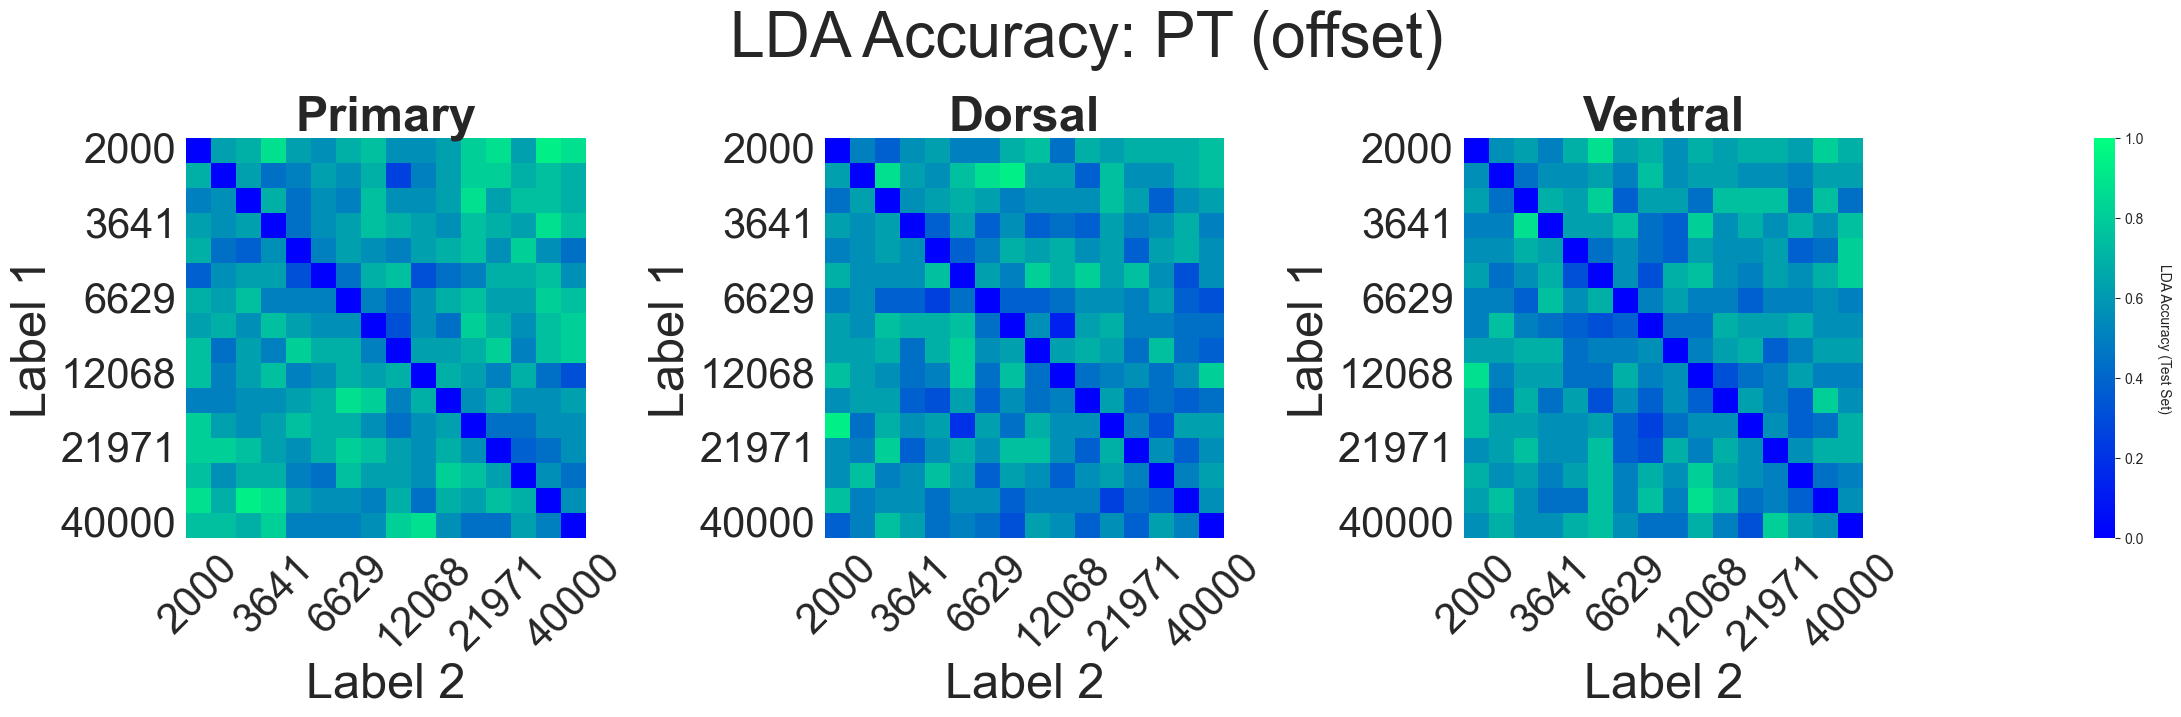

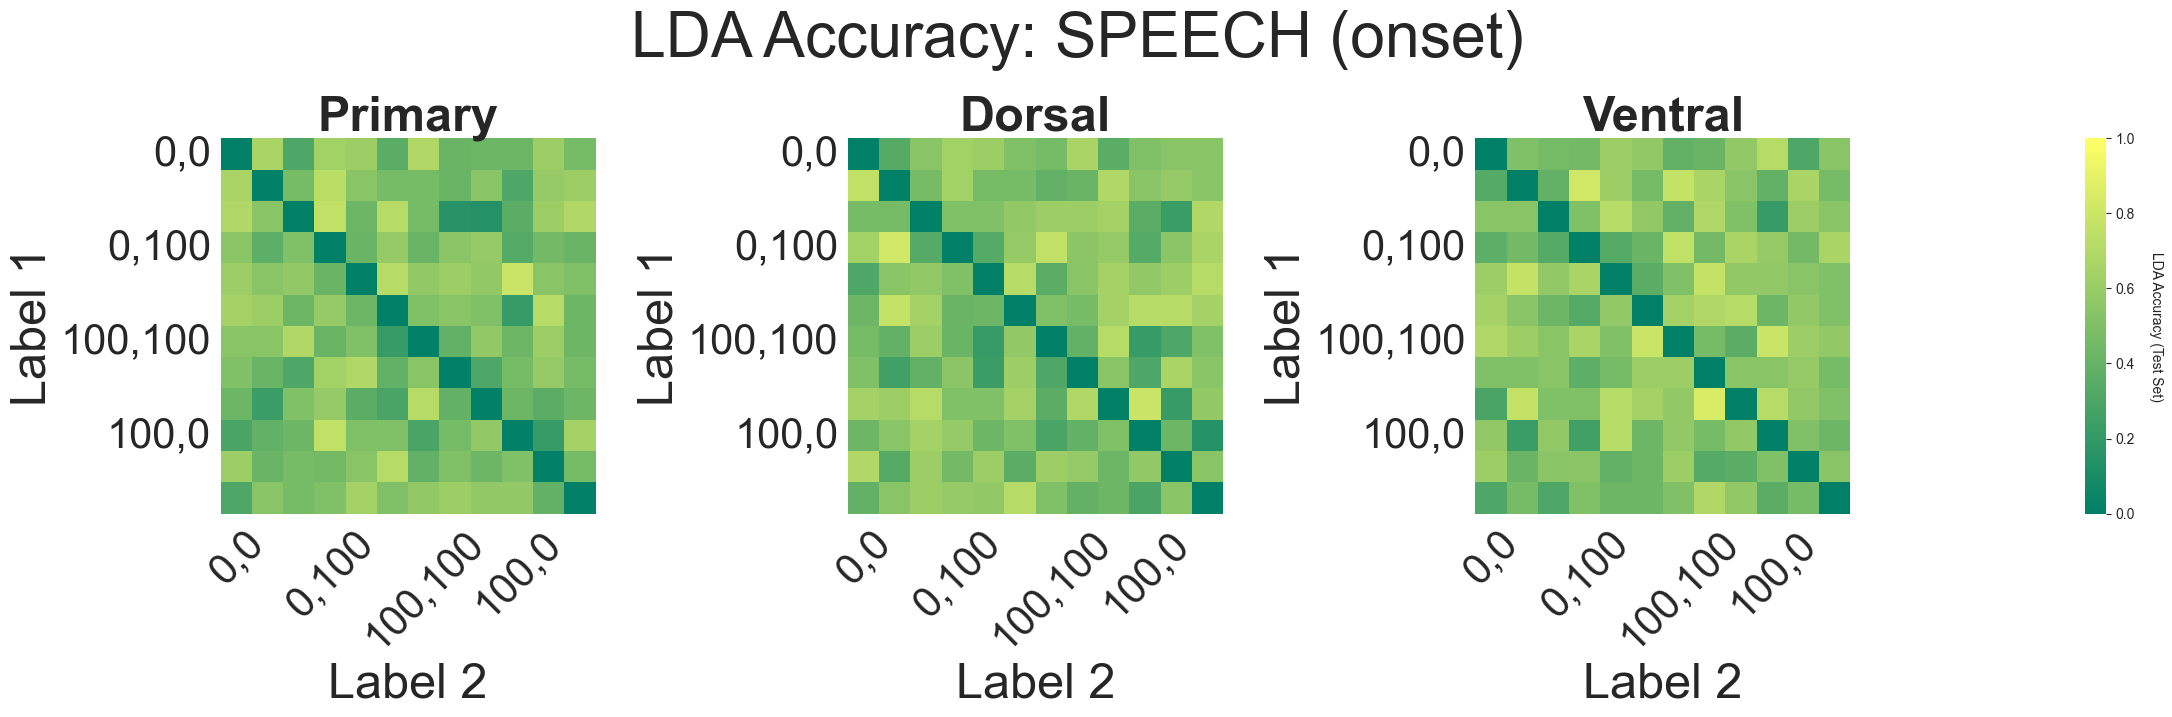

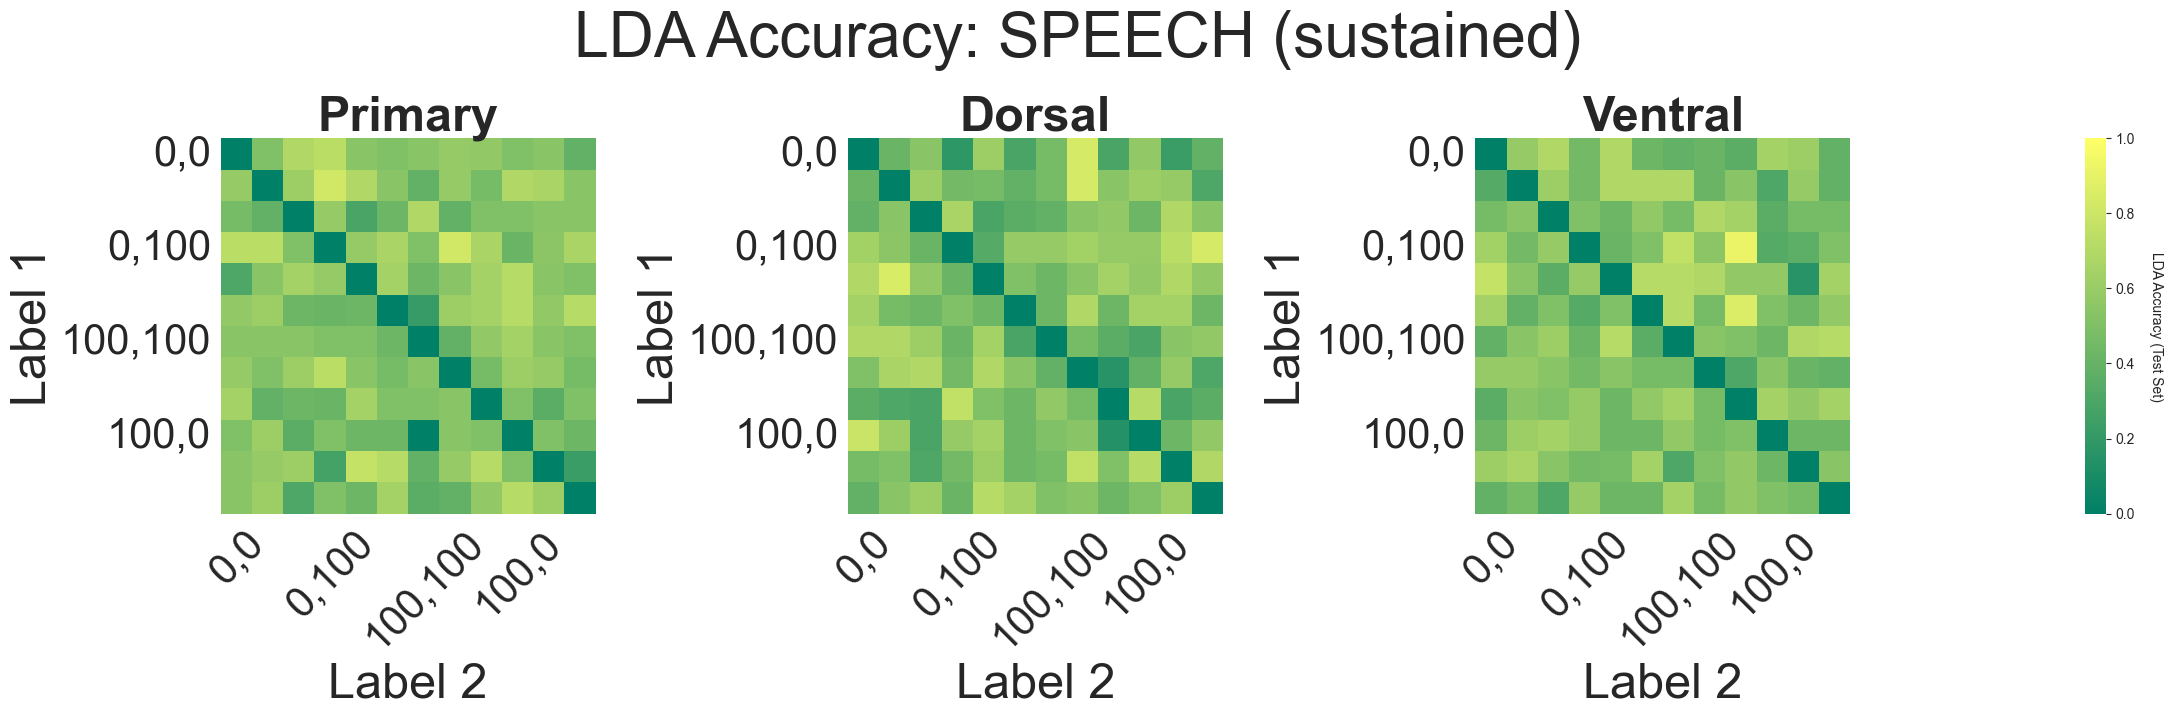

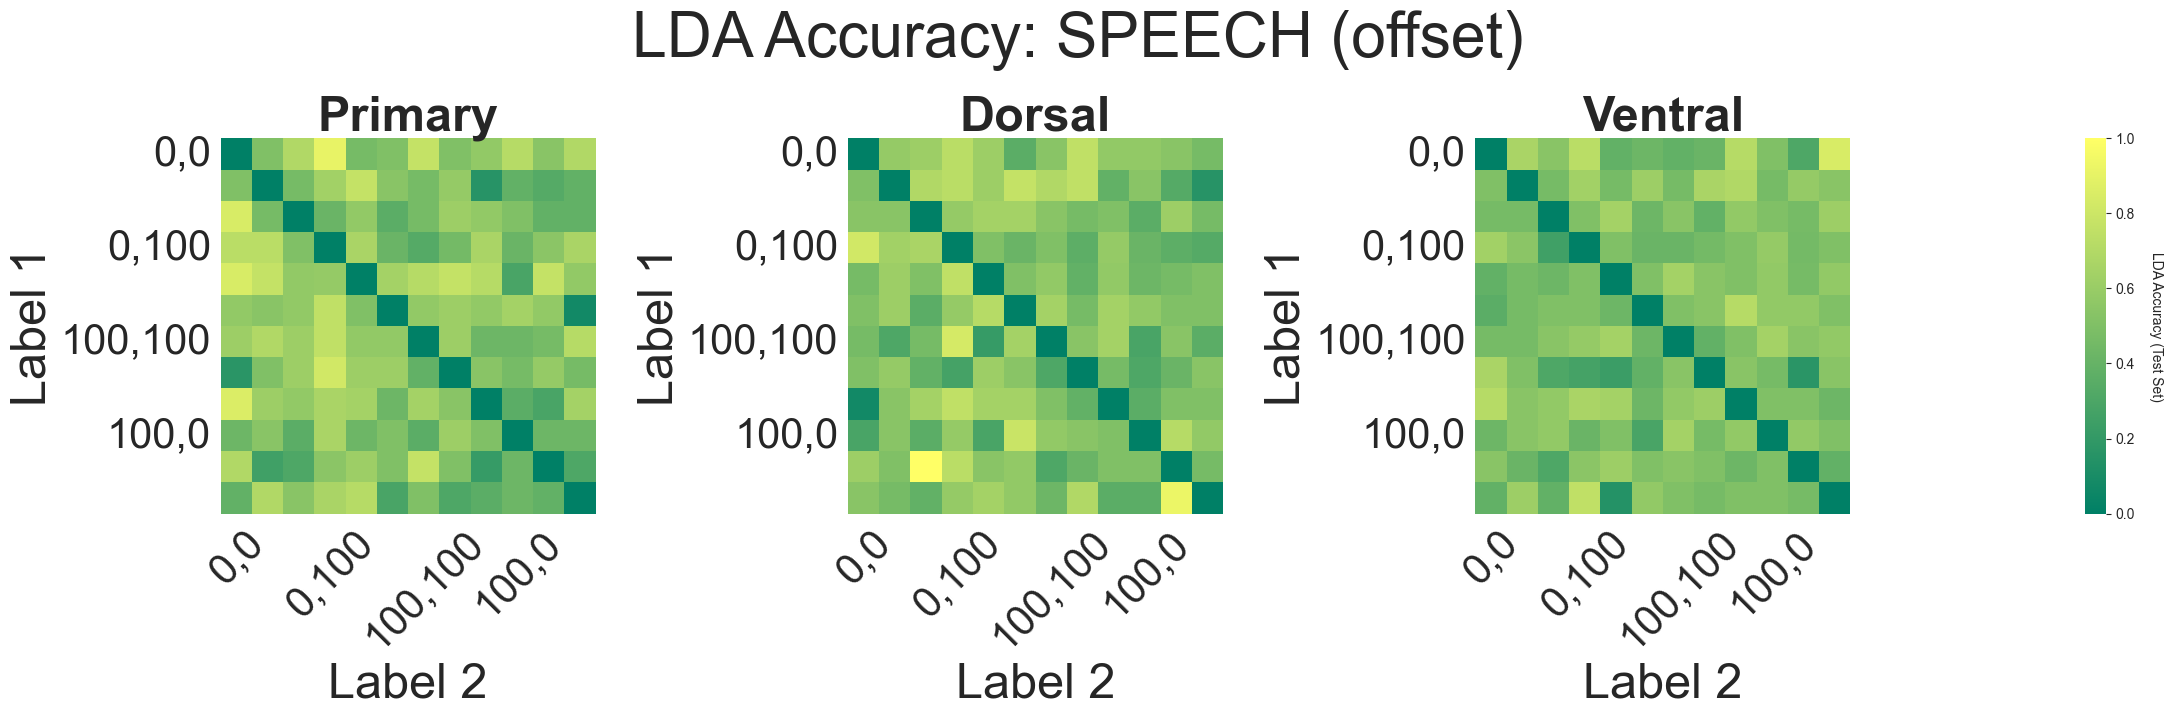

In [32]:
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

save_path = "/Users/zoetomlinson/Desktop/GitHub/neuronalDataResearch/Figures/Population Plots"
lda = LinearDiscriminantAnalysis()
lda_dict = {}
spike_windows = ['onset', 'sustained', 'offset']
all_lda_vals = []

for sound_type in ['AM', 'PT', 'speech']:
    for spike_window in spike_windows:
        for brain_area in params.targetSiteNames:
            key = (brain_area, sound_type, spike_window)
            X_array = data_dict[key]['X']
            Y_array = data_dict[key]['Y']
            
            if sound_type == 'speech':
                vot_values = Y_array[:, 0]
                ft_values = Y_array[:, 1]
                unique_freqs = params.unique_labels
            else:
                unique_freqs = sorted(set(Y_array))

            lda_array = np.zeros((len(unique_freqs), len(unique_freqs)))

            for i, freq1 in enumerate(unique_freqs):
                for j, freq2 in enumerate(unique_freqs):
                    if i == j:
                        continue

                    if sound_type == 'speech':
                        mask_freq1 = (vot_values == freq1[0]) & (ft_values == freq1[1])
                        mask_freq2 = (vot_values == freq2[0]) & (ft_values == freq2[1])
                    else:
                        mask_freq1 = Y_array == freq1
                        mask_freq2 = Y_array == freq2

                    trials_freq1 = X_array[mask_freq1]
                    trials_freq2 = X_array[mask_freq2]

                    if len(trials_freq1) < 4 or len(trials_freq2) < 4:
                        lda_array[i, j] = np.nan
                        continue

                    X_pair = np.vstack([trials_freq1, trials_freq2])
                    y_pair = np.array([0]*len(trials_freq1) + [1]*len(trials_freq2))

                    try:
                        X_train, X_test, y_train, y_test = train_test_split(X_pair, y_pair, test_size=0.2, stratify=y_pair)
                        lda.fit(X_train, y_train)
                        accuracy = lda.score(X_test, y_test)
                    except Exception:
                        accuracy = np.nan

                    lda_array[i, j] = accuracy

            lda_dict[(brain_area, sound_type, spike_window)] = lda_array
            all_lda_vals.append(lda_array.flatten())

# Global color scale for all plots
all_lda_vals = np.concatenate(all_lda_vals)
global_min, global_max = np.nanmin(all_lda_vals), np.nanmax(all_lda_vals)

for sound_type in ['AM', 'PT', 'speech']:
    for spike_window in spike_windows:
        fig = plt.figure(figsize=(22, 7))
        fig.suptitle(f"LDA Accuracy: {sound_type.upper()} ({spike_window})", fontsize=45)
        gs = gridspec.GridSpec(1, len(params.targetSiteNames) + 1, width_ratios=[1]*len(params.targetSiteNames) + [0.05])
        axs = [fig.add_subplot(gs[i]) for i in range(len(params.targetSiteNames))]
        cbar_ax = fig.add_subplot(gs[-1])

        for idx, brain_area in enumerate(params.targetSiteNames):
            lda_array = lda_dict[(brain_area, sound_type, spike_window)]

            if sound_type == 'speech':
                all_labels = [f"{vot},{ft}" for vot, ft in params.unique_labels]
                label_mask = np.arange(len(all_labels)) % 3 == 0
            else:
                all_freqs = sorted(set(data_dict[(brain_area, sound_type, spike_window)]['Y']))
                all_labels = [str(int(round(val))) for val in all_freqs]
                label_mask = np.arange(len(all_labels)) % 3 == 0

            x_labels = [label if show else "" for label, show in zip(all_labels, label_mask)]
            y_labels = [label if show else "" for label, show in zip(all_labels, label_mask)]

            sns.heatmap(lda_array, cmap=params.sound_colormaps[sound_type],
                        xticklabels=x_labels, yticklabels=y_labels,
                        vmin=global_min, vmax=global_max,
                        ax=axs[idx], cbar=(idx == 0), cbar_ax=cbar_ax if idx == 0 else None)

            axs[idx].set_xlabel("Label 2", size=35)
            axs[idx].set_ylabel("Label 1", size=35)
            axs[idx].tick_params(axis='x', labelsize=30, rotation=45)
            axs[idx].tick_params(axis='y', labelsize=30, rotation=0)
            axs[idx].set_title(params.short_names.get(brain_area, brain_area), fontsize=35, fontweight="bold")
            axs[idx].set_aspect("equal")

        cbar_ax.set_ylabel('LDA Accuracy (Test Set)', rotation=270, labelpad=20)
        plt.tight_layout(rect=[0, 0, 1, 0.95], w_pad=0.5, h_pad=1.0)
        filename = f"{sound_type}_{spike_window}_LDA_heatmap.png"
        plt.savefig(os.path.join(save_path, filename), bbox_inches='tight')

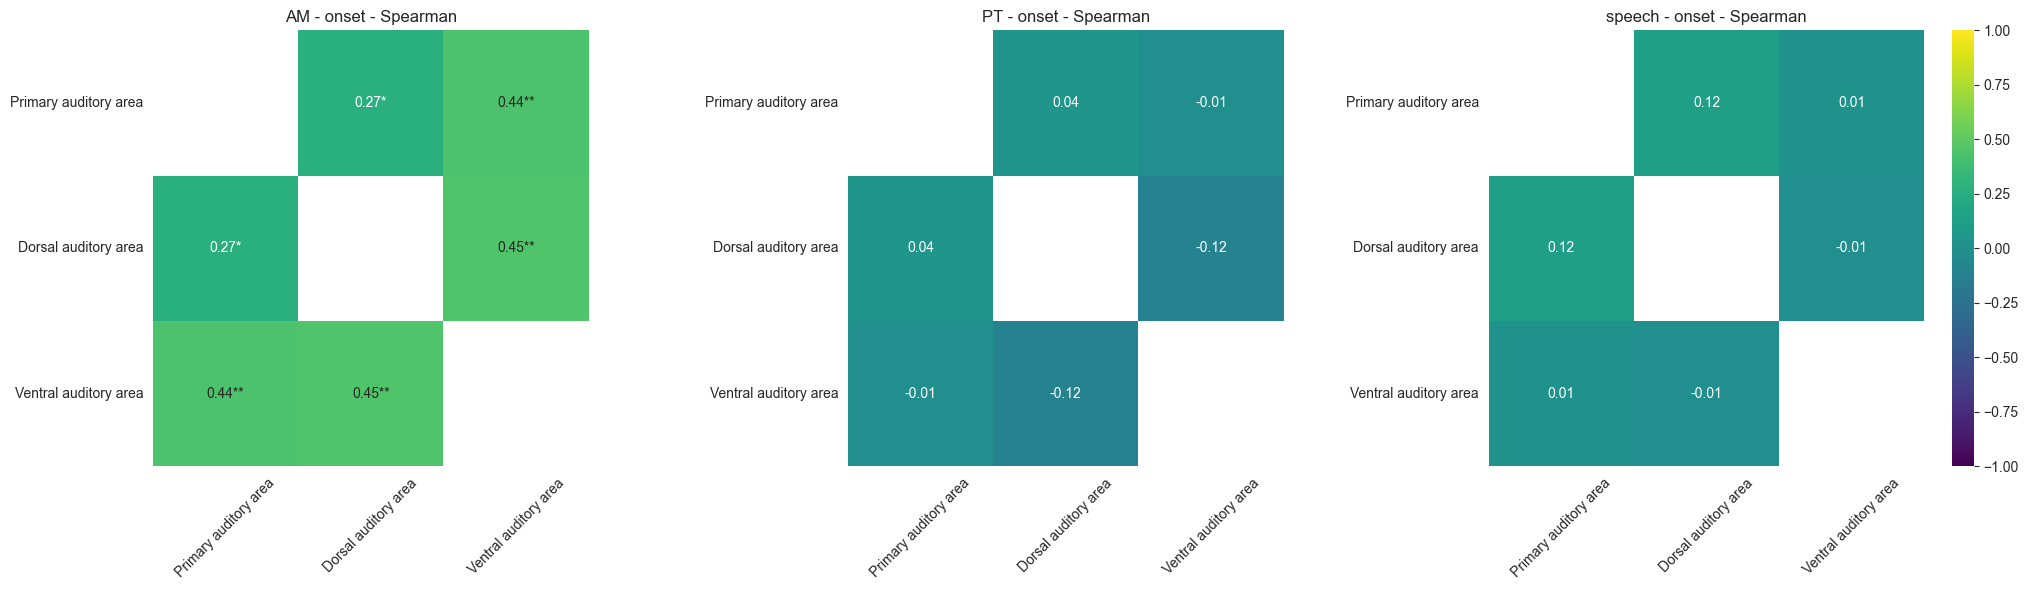

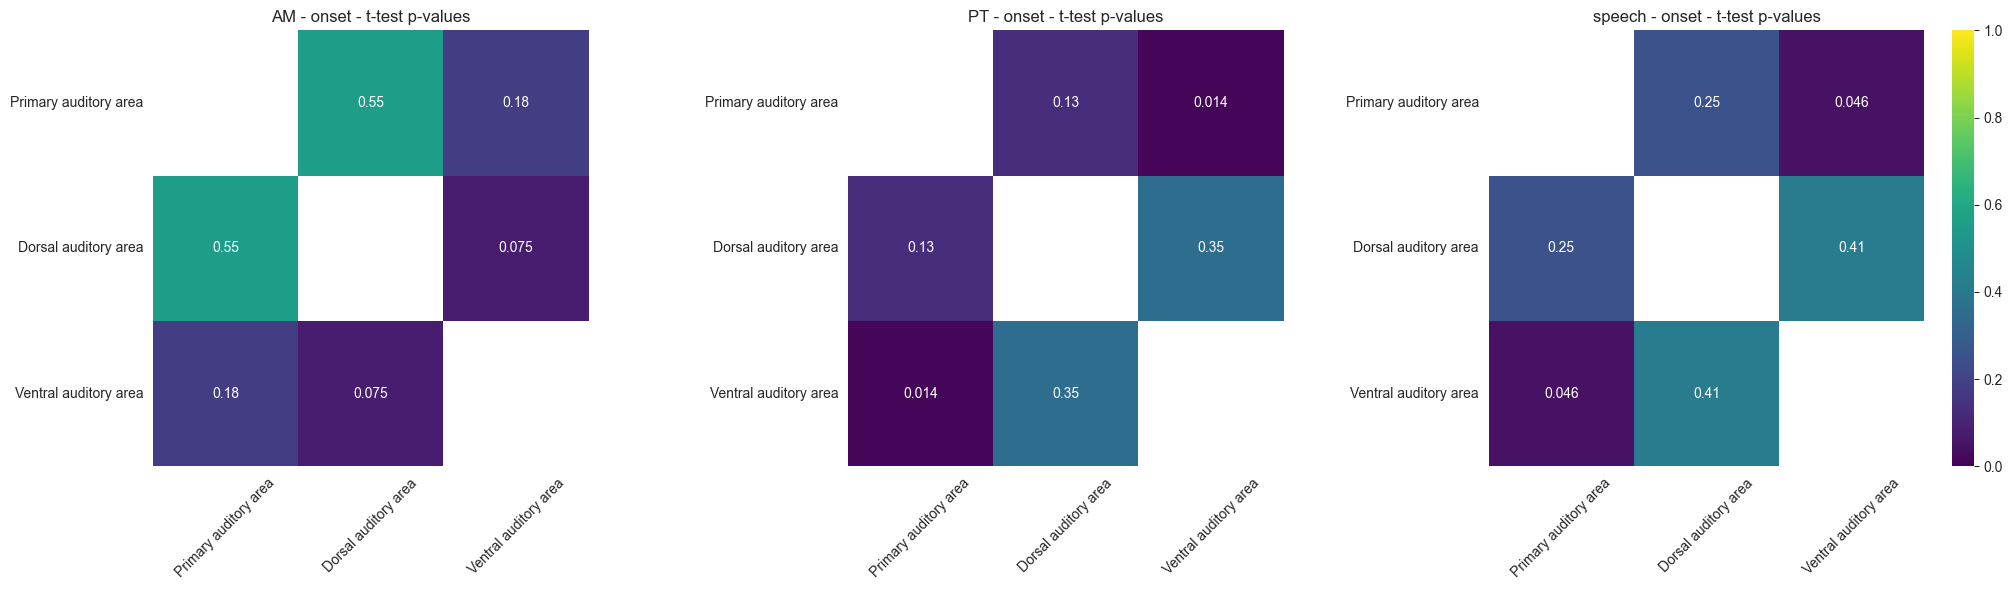

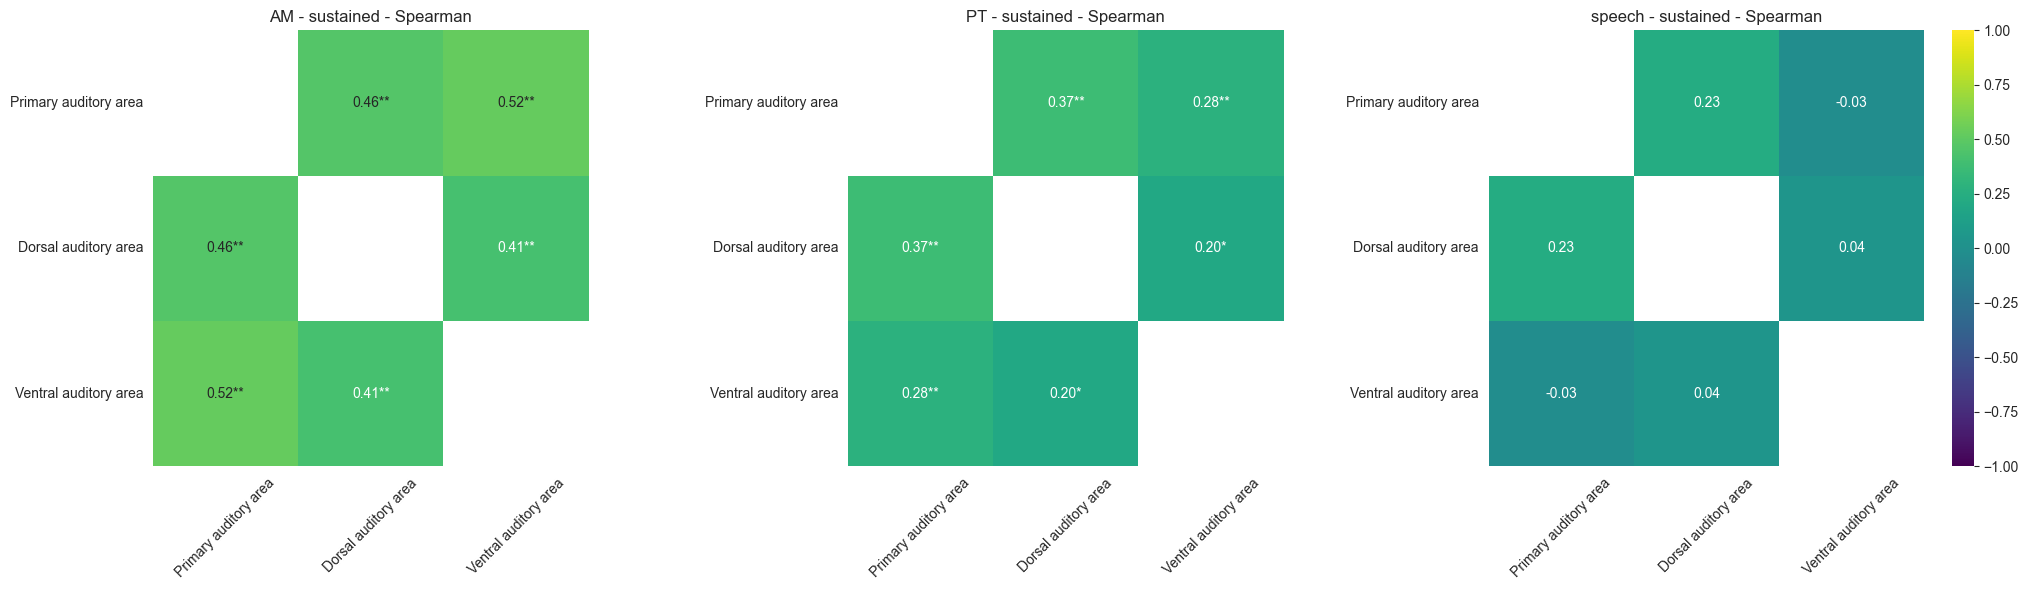

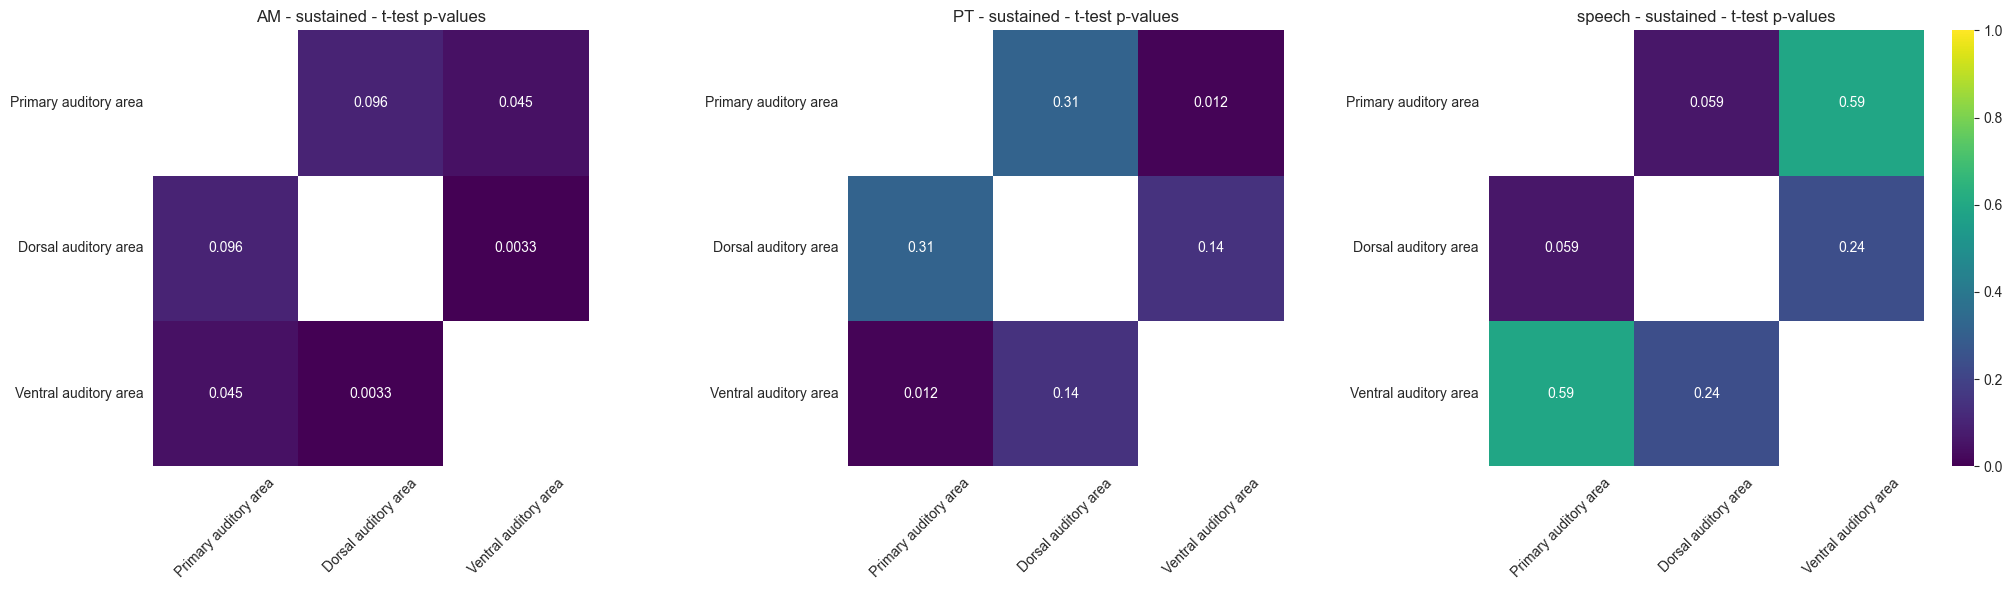

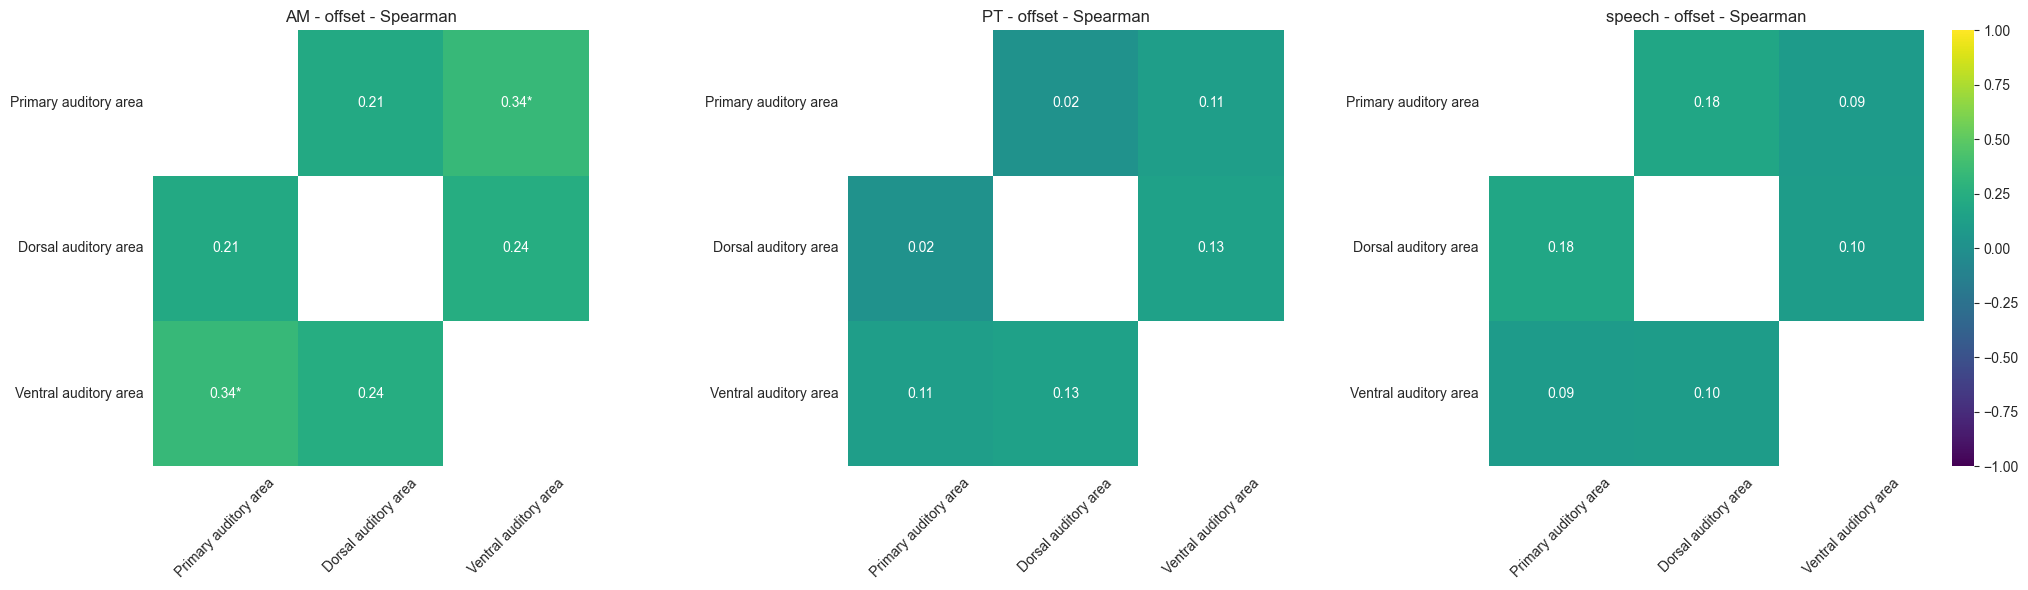

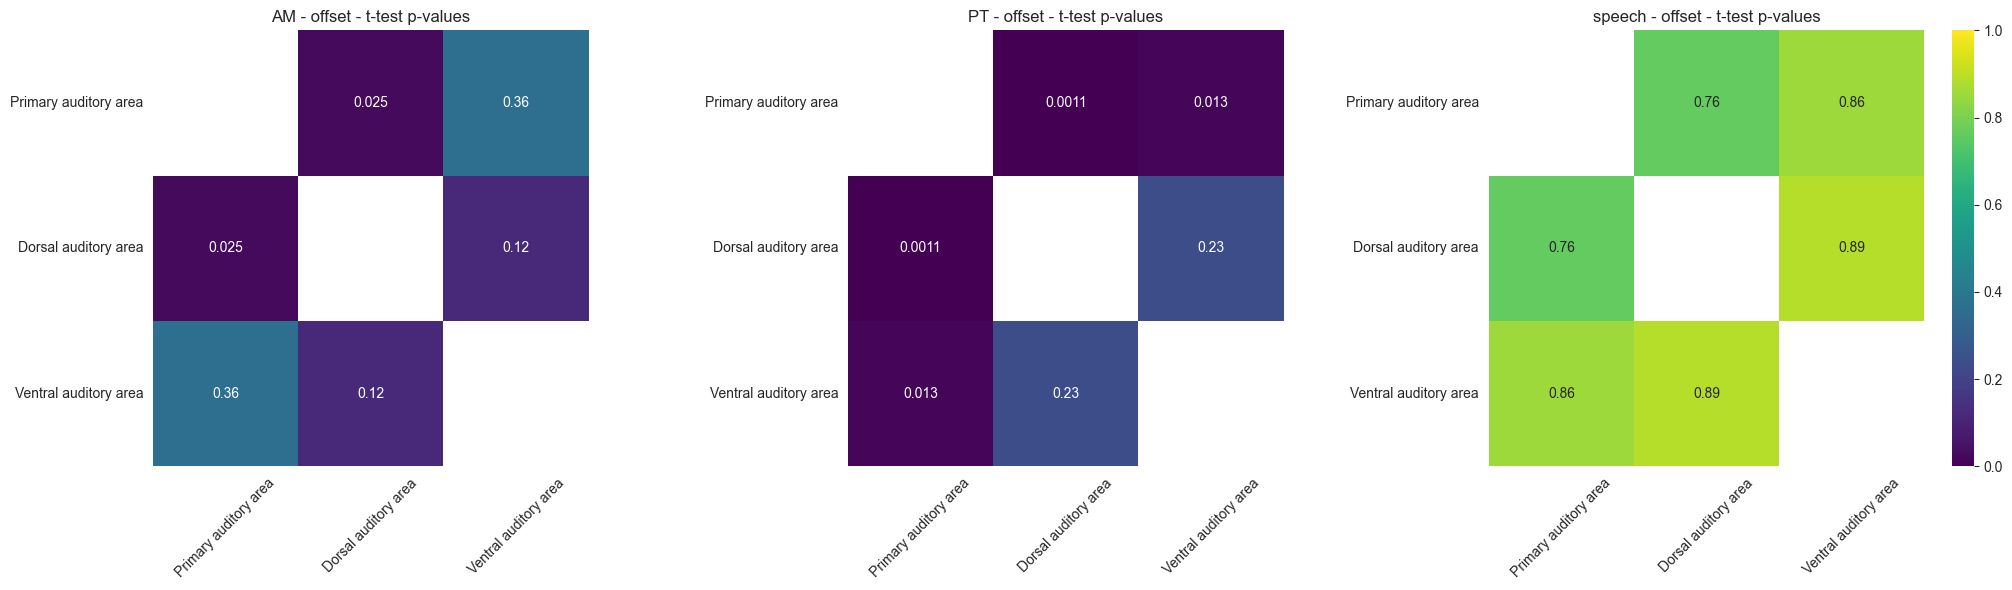

In [33]:
import pandas as pd
from scipy.stats import spearmanr, ttest_rel
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

spike_windows = ['onset', 'sustained', 'offset']
sound_types = ['AM', 'PT', 'speech']
areas = params.targetSiteNames  # List of brain area names

significant_pairs = []

for spike_win in spike_windows:
    fig_corr, axs_corr = plt.subplots(1, 3, figsize=(21, 6))
    fig_pval, axs_pval = plt.subplots(1, 3, figsize=(21, 6))

    for idx, sound_type in enumerate(sound_types):
        n_areas = len(areas)

        # Initialize correlation and p-value matrices
        corr_matrix = pd.DataFrame(np.nan, index=areas, columns=areas)
        pval_matrix = pd.DataFrame(np.nan, index=areas, columns=areas)
        annot_matrix = pd.DataFrame('', index=areas, columns=areas)

        combos = list(itertools.combinations(areas, 2))
        for brain1, brain2 in combos:
            matrix1 = lda_dict.get((brain1, sound_type, spike_win))
            matrix2 = lda_dict.get((brain2, sound_type, spike_win))

            if matrix1 is None or matrix2 is None or matrix1.shape != matrix2.shape:
                print(f"Skipping {brain1} vs {brain2} for {sound_type} ({spike_win}) due to shape mismatch.")
                continue

            # Take only the upper triangle, excluding diagonal
            mask = np.triu(np.ones(matrix1.shape), k=1).astype(bool)
            flat1 = matrix1[mask]
            flat2 = matrix2[mask]

            # Spearman and paired t-test
            rho, spearman_p = spearmanr(flat1, flat2)
            t_stat, ttest_p = ttest_rel(flat1, flat2)

            if ttest_p < 0.05:
                significant_pairs.append((spike_win, sound_type, brain1, brain2))

            # Fill matrices symmetrically
            corr_matrix.loc[brain1, brain2] = corr_matrix.loc[brain2, brain1] = rho
            pval_matrix.loc[brain1, brain2] = pval_matrix.loc[brain2, brain1] = ttest_p

            # Annotate Spearman with stars
            stars = '**' if spearman_p < 0.01 else '*' if spearman_p < 0.05 else ''
            text = f"{rho:.2f}{stars}"
            annot_matrix.loc[brain1, brain2] = annot_matrix.loc[brain2, brain1] = text

        # Plot Spearman
        sns.heatmap(
            corr_matrix.astype(float),
            annot=annot_matrix.values,
            fmt='',
            cmap='viridis',
            vmin=-1,
            vmax=1,
            square=True,
            ax=axs_corr[idx],
            cbar=(idx == len(sound_types) - 1)
        )
        axs_corr[idx].set_title(f"{sound_type} - {spike_win} - Spearman")
        axs_corr[idx].tick_params(axis='x', rotation=45)
        axs_corr[idx].tick_params(axis='y', rotation=0)

        # Plot Paired t-test p-values
        sns.heatmap(
            pval_matrix.astype(float),
            annot=True,
            cmap='viridis',
            vmin=0,
            vmax=1,
            square=True,
            ax=axs_pval[idx],
            cbar=(idx == len(sound_types) - 1)
        )

        # White-out diagonals
        for i in range(n_areas):
            axs_corr[idx].add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='white', lw=0))
            axs_pval[idx].add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='white', lw=0))

        axs_pval[idx].set_title(f"{sound_type} - {spike_win} - t-test p-values")
        axs_pval[idx].tick_params(axis='x', rotation=45)
        axs_pval[idx].tick_params(axis='y', rotation=0)

    fig_corr.tight_layout()
    fig_pval.tight_layout()

    fig_corr.savefig(os.path.join(save_path, f"{spike_win}_LDA_spearman_heatmaps.png"))
    fig_pval.savefig(os.path.join(save_path, f"{spike_win}_LDA_ttest_pval_heatmaps.png"))

/var/folders/l9/v78y7h896278tzntj74hkdkr0000gn/T/ipykernel_66880/1228195193.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sound_order, fontsize=18)


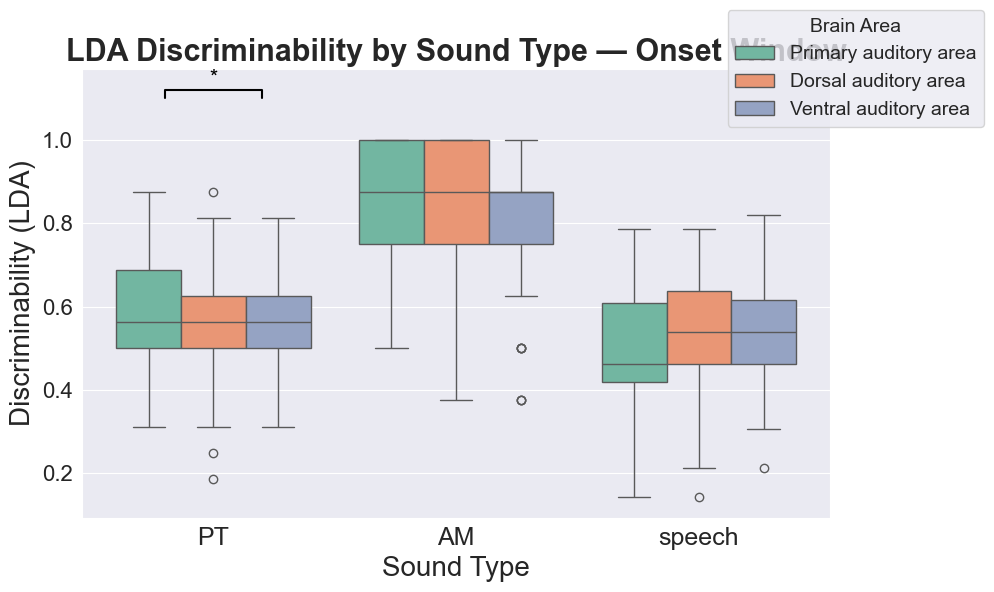

/var/folders/l9/v78y7h896278tzntj74hkdkr0000gn/T/ipykernel_66880/1228195193.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sound_order, fontsize=18)


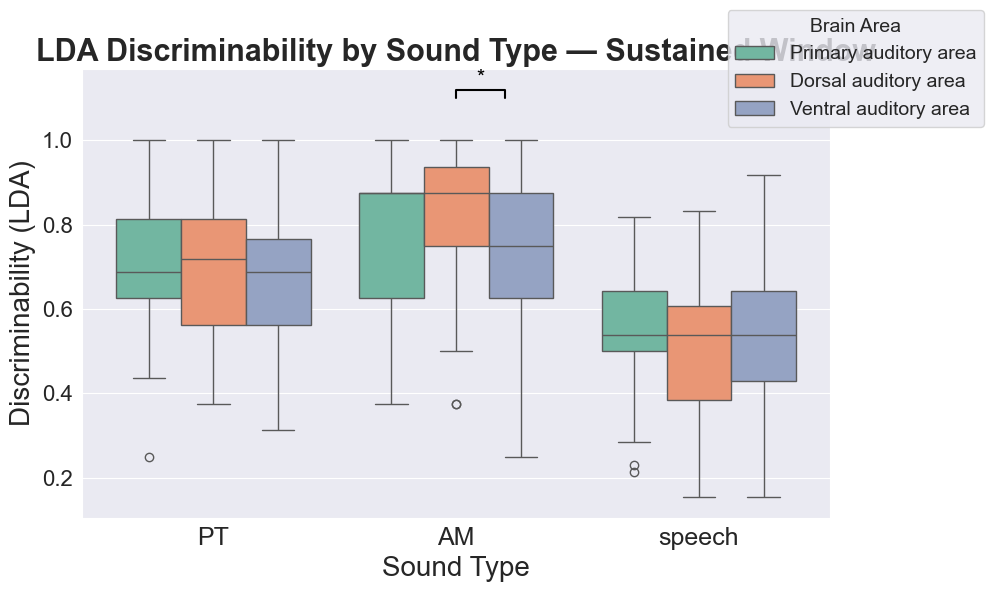

/var/folders/l9/v78y7h896278tzntj74hkdkr0000gn/T/ipykernel_66880/1228195193.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sound_order, fontsize=18)


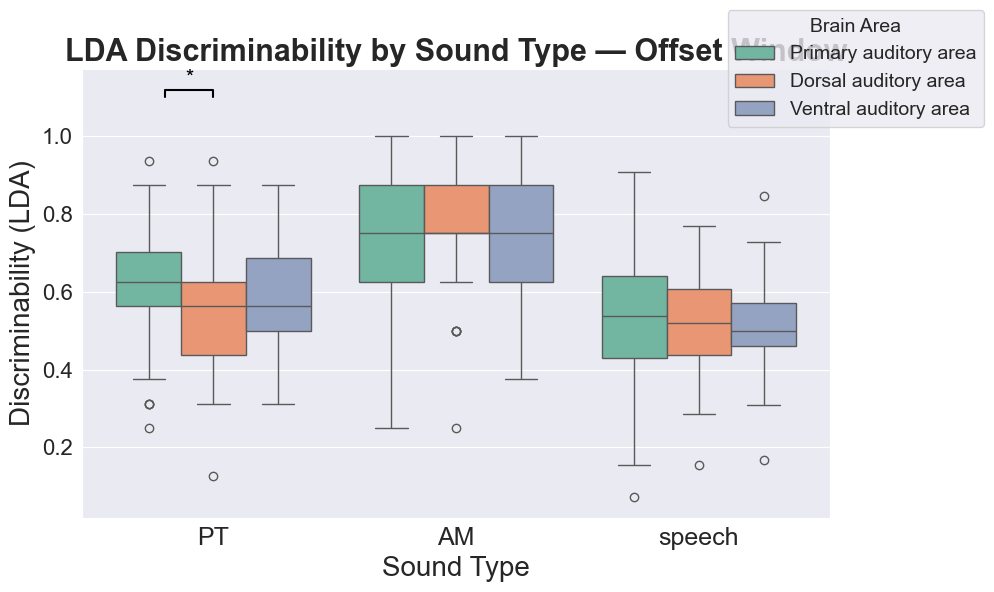

In [34]:
from scipy.stats import f_oneway
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from matplotlib import cm

# Define your variables
sound_order = ['PT', 'AM', 'speech']
sound_palette = {
    'PT': cm.winter(0.5),
    'AM': cm.magma(0.5),
    'speech': cm.summer(0.5)
}
spike_windows = ['onset', 'sustained', 'offset']
save_path = "/Users/zoetomlinson/Desktop/GitHub/neuronalDataResearch/Figures/Population Plots"

for spike_window in spike_windows:
    lda_data = []
    significant_pairs = []

    for sound_type in sound_order:
        for area in areas:
            matrix = lda_dict.get((area, sound_type, spike_window))
            if matrix is None:
                continue

            # Flatten upper triangle
            upper_triangle_mask = np.triu(np.ones(matrix.shape), k=1).astype(bool)
            flat_lda = matrix[upper_triangle_mask]

            for val in flat_lda:
                lda_data.append({
                    'Brain Area': area,
                    'Sound': sound_type,
                    'Spike Window': spike_window,
                    'LDA': val
                })

    # Create dataframe
    lda_df = pd.DataFrame(lda_data)

    # One-way ANOVA + Tukey HSD per sound type
    for sound_type in sound_order:
        group_data = [
            lda_df[(lda_df['Sound'] == sound_type) & (lda_df['Brain Area'] == area)]['LDA']
            for area in areas
        ]

        # Run one-way ANOVA
        f_stat, p_anova = f_oneway(*group_data)

        if p_anova < 0.05:
            subset_df = lda_df[lda_df['Sound'] == sound_type]
            tukey = pairwise_tukeyhsd(endog=subset_df['LDA'],
                                      groups=subset_df['Brain Area'],
                                      alpha=0.05)
            for result in tukey.summary().data[1:]:
                area1, area2, _, _, _, p_adj, reject = result
                if reject:
                    significant_pairs.append((sound_type, area1, area2))

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(
        data=lda_df,
        x='Sound',
        y='LDA',
        hue='Brain Area',
        hue_order=areas,
        palette='Set2',
        ax=ax
    )

    plt.title(f'LDA Discriminability by Sound Type — {spike_window.title()} Window', fontweight='bold', fontsize=22)

    # Offset logic
    box_offsets = {area: i * 0.2 - 0.2 for i, area in enumerate(areas)}
    stack_base_y = lda_df['LDA'].max() + 0.1
    stack_height = 0.07
    stack_counter = 0

    for sound, area1, area2 in significant_pairs:
        if area1 not in areas or area2 not in areas:
            continue
        x = sound_order.index(sound)
        x1 = x + box_offsets[area1]
        x2 = x + box_offsets[area2]
        y = stack_base_y + stack_counter * stack_height
        ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1.5, c='k')
        ax.text((x1 + x2) / 2, y + 0.025, '*', ha='center', va='bottom', color='k', fontsize=15)
        stack_counter += 1

    ax.set_ylabel('Discriminability (LDA)', fontsize=20)
    ax.set_xlabel("Sound Type", fontsize=20)
    ax.set_xticklabels(sound_order, fontsize=18)
    ax.tick_params(axis='y', labelsize=16)

    ax.legend(title='Brain Area', title_fontsize=14, fontsize=14, bbox_to_anchor=(0.85, 0.85))

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"boxplot_LDA_{spike_window}.png"))
    plt.show()